<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.cross_validation import cross_val_score, cross_val_predict
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.feature_selection import RFECV

ss = StandardScaler()

sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/home/mahendra/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [2]:
# Load the data
house = pd.read_csv('/home/mahendra/Desktop/Documents/Project3/housing.csv')
house.shape

(1460, 81)

In [3]:
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100
house.head(3)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [4]:
house.dtypes

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [5]:
# to check for the rows which are not in residential zone.
# house[(house.MSZoning=='A')| (house.MSZoning=='I') | (house.MSZoning=='C') | (house.MSZoning=='RP')].shape
house.LotFrontage.fillna(house.LotFrontage.median(),inplace=True)

print house.MSZoning.value_counts()
house=house[(house.MSZoning=='RL')| (house.MSZoning=='RM') | (house.MSZoning=='RH') | (house.MSZoning=='FV')]
house.reset_index(inplace=True)
house.shape

RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


(1450, 82)

In [6]:
# Considering Abnormal sales and sales within Family can be differnet and avoiding those 
# might be help for better modeling and predictions
house[(house.SaleCondition!='Abnorml') & (house.SaleCondition!='Family')].shape

(1334, 82)

In [7]:
house=house[(house.SaleCondition!='Abnorml') & (house.SaleCondition!='Family')]
house.reset_index(inplace=True)

In [8]:
for col in house:
    if house[col].isnull().sum() > 0:
        print col,house[col].isnull().sum()
        

# As of now not droping any columns or rows because not sure whether it will be in anyuse later.

Alley 1257
MasVnrType 8
MasVnrArea 8
BsmtQual 36
BsmtCond 36
BsmtExposure 37
BsmtFinType1 36
BsmtFinType2 37
Electrical 1
FireplaceQu 610
GarageType 67
GarageYrBlt 67
GarageFinish 67
GarageQual 67
GarageCond 67
PoolQC 1329
Fence 1092
MiscFeature 1285


In [9]:
# will decide whether to drop or can be used in some way when we use those columns for analysis.

In [10]:
for col in house:
    if house[col].isnull().sum() > 0:
        print col,house[col].nunique()

Alley 2
MasVnrType 4
MasVnrArea 309
BsmtQual 4
BsmtCond 4
BsmtExposure 4
BsmtFinType1 6
BsmtFinType2 6
Electrical 4
FireplaceQu 5
GarageType 6
GarageYrBlt 96
GarageFinish 3
GarageQual 5
GarageCond 5
PoolQC 2
Fence 4
MiscFeature 4


In [11]:
print(house.duplicated().sum())


0


In [12]:
# Age of the house while it sold
house['Age_while_Sale']=house['YrSold']-house['YearBuilt']
# Age of the house after rebuild
house['Rebuild_age_while_sale']=house['YrSold']-house['YearRemodAdd']
# currrent age of the house from first make . Assuming current year is 2010 from the data
house['age']= 2010-house['YearBuilt']

In [13]:
house.describe()

,level_0,index,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice,Age_while_Sale,Rebuild_age_while_sale,age
count,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1326.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1267.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000,1334.000000
mean,723.384558,729.239130,730.239130,56.776612,69.946027,10610.573463,6.149925,5.595202,1972.494003,1985.864318,106.562594,447.140930,44.721139,569.391304,1061.253373,1165.589955,351.925037,4.994003,1522.508996,0.432534,0.053223,1.580960,0.394303,2.863568,1.043478,6.534483,0.630435,1979.470403,1.790855,478.633433,96.535232,47.257871,20.417541,3.434783,14.772114,2.219640,46.371814,6.302849,2007.836582,184358.968516,35.342579,21.972264,37.505997
std,419.495927,422.333791,422.333791,42.089458,21.797026,10353.201474,1.377129,1.108993,30.006169,20.406897,185.003536,456.661439,157.453670,447.822143,444.925726,385.693250,437.710211,44.501709,519.988454,0.519267,0.231148,0.548309,0.505481,0.799085,0.214756,1.621293,0.645141,24.350158,0.738324,212.084400,126.830400,65.279210,58.059379,29.704696,55.635986,36.639734,518.341199,2.666180,1.318224,78771.015650,30.061383,20.406374,30.006169
min,0.000000,0.000000,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1906.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,39300.000000,0.000000,-1.000000,0.000000
25%,359.250000,362.250000,363.250000,20.000000,60.000000,7588.500000,5.000000,5.000000,1954.000000,1968.000000,0.000000,0.000000,0.000000,218.000000,796.500000,882.000000,0.000000,0.000000,1140.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1962.000000,1.000000,344.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,132500.000000,7.000000,4.000000,8.250000
50%,720.500000,726.500000,727.500000,50.000000,69.000000,9522.500000,6.000000,5.000000,1975.000000,1995.000000,0.000000,386.500000,0.000000,473.500000,992.000000,1089.000000,0.000000,0.000000,1476.500000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1982.000000,2.000000,480.000000,0.000000,27.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,166500.000000,33.000000,13.000000,35.000000
75%,1085.750000,1094.750000,1095.750000,70.000000,79.000000,11642.000000,7.000000,6.000000,2001.750000,2004.000000,168.000000,718.250000,0.000000,809.500000,1306.000000,1393.500000,739.000000,0.000000,1788.000000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2003.000000,2.000000,576.000000,169.000000,69.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,216375.000000,53.000000,39.750000,56.000000
max,1449.000000,1459.000000,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,1872.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,6.000000,3.000000,12.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,386.000000,508.000000,480.000000,738.000

In [14]:
for col in house.columns:
    if house[col].dtypes != object:
        if house[col].isnull().sum() > 0:
            print col,house[col].isnull().sum() 
# Check what does those 3 column means
#LotFrontage: Linear feet of street connected to property
#MasVnrArea: Masonry veneer area in square feet
#GarageYrBlt: Year garage was built

MasVnrArea 8
GarageYrBlt 67


In [15]:
house[house['Rebuild_age_while_sale']<0]
# Houses that have remodeled after Sale.

,level_0,index,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Age_while_Sale,Rebuild_age_while_sale,age
483,519,523,524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,Gtl,Edwards,PosN,PosN,1Fam,2Story,10,5,2007,2008,Hip,CompShg,CemntBd,CmentBd,Stone,762.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2260,Unf,0,878,3138,GasA,Ex,Y,SBrkr,3138,1538,0,4676,1,0,3,1,3,1,Ex,11,Typ,1,Gd,BuiltIn,2007.0,Fin,3,884,TA,TA,Y,208,406,0,0,0,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750,0,-1,3


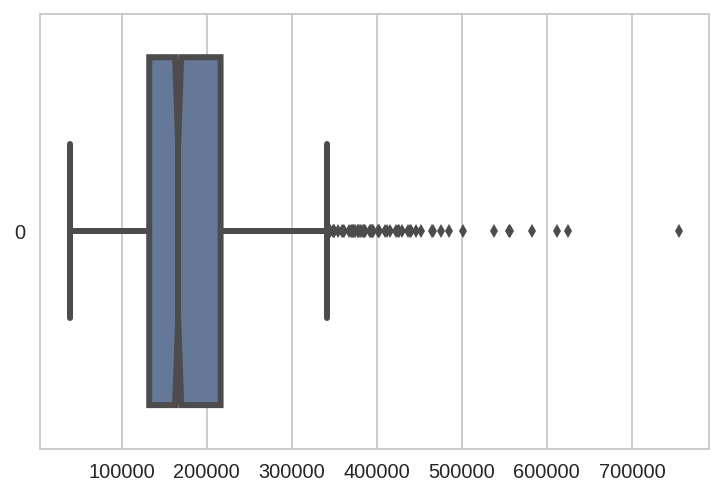

In [16]:
sns.boxplot(data=house.SalePrice, orient='h', fliersize=5,linewidth=3, notch=True, saturation=0.5)
plt.show()

#This shows we have a lot of outliers in the higher end of price.
# Its better to avoid those to make the model since we are using the model to predit price that we have to buy.
# If the higher end datas are there it can make the price a bit high for every other houses.

In [17]:
price=house.SalePrice
Q1=price.describe()[4]
Q3=price.describe()[6]
IQR= Q3-Q1

upper_cutoff=Q3+1.5*IQR


In [18]:
upper_cutoff

342187.5

In [19]:
# house=house[house['SalePrice']<=upper_cutoff]
# # house.reset_index(range(0,len(house)))
# house[house['SalePrice']<=upper_cutoff].shape

In [20]:
# Check the data_description.txt to analyse and figure out what each variable means and which all are 
# useful for us in the upcoming analysis.

for col in house.columns:
    if house[col].dtypes != object:
        print col

level_0
index
Id
MSSubClass
LotFrontage
LotArea
OverallQual
OverallCond
YearBuilt
YearRemodAdd
MasVnrArea
BsmtFinSF1
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
1stFlrSF
2ndFlrSF
LowQualFinSF
GrLivArea
BsmtFullBath
BsmtHalfBath
FullBath
HalfBath
BedroomAbvGr
KitchenAbvGr
TotRmsAbvGrd
Fireplaces
GarageYrBlt
GarageCars
GarageArea
WoodDeckSF
OpenPorchSF
EnclosedPorch
3SsnPorch
ScreenPorch
PoolArea
MiscVal
MoSold
YrSold
SalePrice
Age_while_Sale
Rebuild_age_while_sale
age


In [21]:
# Finding out the total bathrooms for better relationship
house["Total_Full_Bath"]=house['BsmtFullBath']+house['FullBath']
house["Total_Half_Bath"]=0.5*(house['BsmtHalfBath']+house['HalfBath'])

In [22]:
# Trying to figuere out the Fixed features that are useful 
#,'Foundation','Neighborhood' should be added after changing to dummies
fixed_continous=['LotArea','LotFrontage','TotalBsmtSF','GrLivArea','GarageCars','GarageArea','BedroomAbvGr',
            'TotRmsAbvGrd','Fireplaces','ScreenPorch','EnclosedPorch','OpenPorchSF','3SsnPorch','Total_Full_Bath','Total_Half_Bath','Age_while_Sale','Rebuild_age_while_sale']
fixed=house[fixed_continous]

In [23]:
fixed.isnull().sum()

LotArea                   0
LotFrontage               0
TotalBsmtSF               0
GrLivArea                 0
GarageCars                0
GarageArea                0
BedroomAbvGr              0
TotRmsAbvGrd              0
Fireplaces                0
ScreenPorch               0
EnclosedPorch             0
OpenPorchSF               0
3SsnPorch                 0
Total_Full_Bath           0
Total_Half_Bath           0
Age_while_Sale            0
Rebuild_age_while_sale    0
dtype: int64

In [24]:
# # med=fixed.LotFrontage.median()
# # fixed['LotFrontage'].fillna(0, inplace=True)
# # fixed.reset_index(inplace=True)
# fixed['LotFrontage'].fillna((fixed['LotFrontage'].median()), inplace=True)
# fixed.LotFrontage.head(8)

# imputing the median value assuming its hard to have no linear frontage at all with a street.

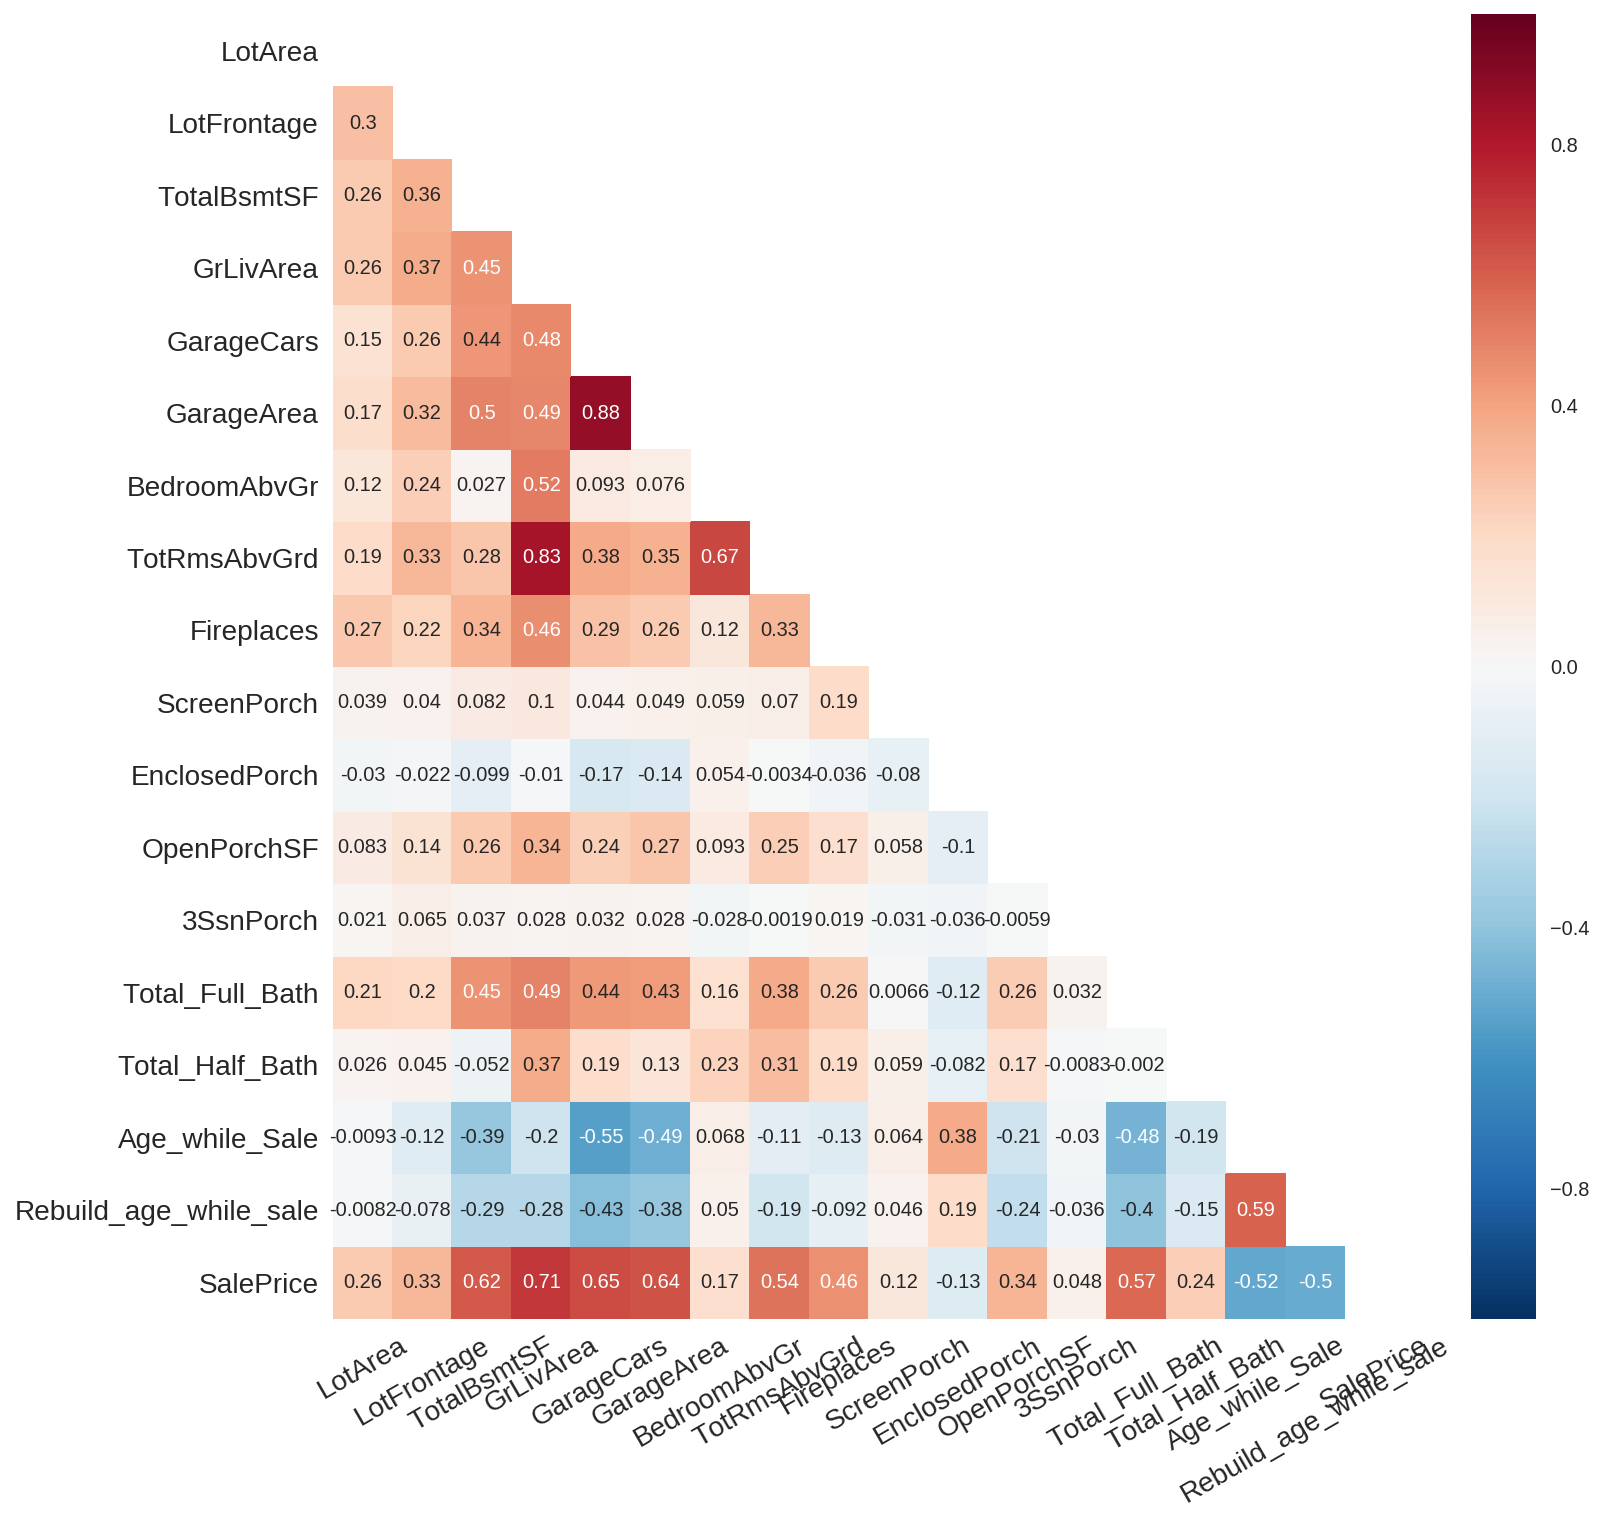

In [25]:
# Lets look the correlation matrix and heat map of the 

## Correlation Heat map
def correlation_heat_map(df):
    corrs = df.corr()

    # Set the default matplotlib figure size:
    fig, ax = plt.subplots(figsize=(12,12))

    # Generate a mask for the upper triangle (taken from seaborn example gallery)
    mask = np.zeros_like(corrs, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Plot the heatmap with seaborn.
    # Assign the matplotlib axis the function returns. This will let us resize the labels.
    ax = sns.heatmap(corrs, mask=mask, annot=True)

    # Resize the labels.
    ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14, rotation=30)
    ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14, rotation=0)

    # If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
    plt.show()

fixed_with_sales = fixed.copy()
fixed_with_sales['SalePrice']= house.SalePrice
correlation_heat_map(fixed_with_sales)


In [26]:
def redundant_pairs(df):
   pairs_to_drop = set()
   cols = df.columns
   for i in range(0, df.shape[1]):
       for j in range(0, i+1):
           pairs_to_drop.add((cols[i],cols[j]))
   return pairs_to_drop

def get_top_abs_corr(df):
   au_corr = df.corr().unstack()
   labels_to_drop = redundant_pairs(df)
   au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
   return au_corr[:]

In [27]:
top_abs_corr = get_top_abs_corr(fixed_with_sales)
# eliminating the correlations that are weakly correlated. 
top_abs_corr=top_abs_corr[(top_abs_corr< -0.5) | (top_abs_corr > 0.5)]
top_abs_corr

GarageCars              GarageArea                0.878591
GrLivArea               TotRmsAbvGrd              0.829915
                        SalePrice                 0.708111
BedroomAbvGr            TotRmsAbvGrd              0.668382
GarageCars              SalePrice                 0.652481
GarageArea              SalePrice                 0.640069
TotalBsmtSF             SalePrice                 0.615455
Age_while_Sale          Rebuild_age_while_sale    0.589076
Total_Full_Bath         SalePrice                 0.573108
TotRmsAbvGrd            SalePrice                 0.544723
GrLivArea               BedroomAbvGr              0.520064
Rebuild_age_while_sale  SalePrice                -0.500047
Age_while_Sale          SalePrice                -0.518485
GarageCars              Age_while_Sale           -0.550038
dtype: float64

In [28]:
# Eliminating correlations that are not related to Sales
for row in top_abs_corr.iteritems():
    if (row[0][0] == 'SalePrice' or row[0][1] == 'SalePrice'):
        print row

(('GrLivArea', 'SalePrice'), 0.70811078109947834)
(('GarageCars', 'SalePrice'), 0.65248137176867049)
(('GarageArea', 'SalePrice'), 0.64006888174699861)
(('TotalBsmtSF', 'SalePrice'), 0.61545503366724064)
(('Total_Full_Bath', 'SalePrice'), 0.57310779881152241)
(('TotRmsAbvGrd', 'SalePrice'), 0.5447227273717995)
(('Rebuild_age_while_sale', 'SalePrice'), -0.50004724952004675)
(('Age_while_Sale', 'SalePrice'), -0.51848511044449308)


In [29]:
# we have the correlations now. From here we can try multiple linear regression with different values.
# Since GarageCars & GarageArea are highly correlated to each other considering only GarageArea. 
# Even though this is a number this makes more sense.
# Since Rebuild_age_while_Sale & Age_while_Sale are highly correlated to each other considering only Age_while_Sale. 

In [30]:
fixed_with_sales['YrSold']=house['YrSold']

In [31]:
fixed_with_sales.columns

Index([u'LotArea', u'LotFrontage', u'TotalBsmtSF', u'GrLivArea', u'GarageCars',
       u'GarageArea', u'BedroomAbvGr', u'TotRmsAbvGrd', u'Fireplaces',
       u'ScreenPorch', u'EnclosedPorch', u'OpenPorchSF', u'3SsnPorch',
       u'Total_Full_Bath', u'Total_Half_Bath', u'Age_while_Sale',
       u'Rebuild_age_while_sale', u'SalePrice', u'YrSold'],
      dtype='object')

In [32]:
# to start with take 2 highest correlation to make model


X_columns=['GrLivArea', 'GarageArea']
y_columns=['SalePrice']
X=fixed_with_sales[X_columns]
y=fixed_with_sales[y_columns]


X_train = fixed_with_sales[fixed_with_sales.YrSold < 2010].loc[:, X_columns]
y_train = fixed_with_sales['SalePrice'][fixed_with_sales.YrSold < 2010]


X_test = fixed_with_sales[fixed_with_sales.YrSold >= 2010].loc[:, X_columns]
y_test = fixed_with_sales['SalePrice'][fixed_with_sales.YrSold >= 2010]

Xs = ss.fit_transform(X)
X_train_s = ss.fit_transform(X_train)
X_test_s = ss.fit_transform(X_test)

print X_train_s.shape, y_train.shape
print X_test_s.shape, y_test.shape


(1173, 2) (1173,)
(161, 2) (161,)


In [33]:

slr = LinearRegression()
slr.fit(X_train_s, y_train)

print "R2 for Train Data",slr.score(X_train_s, y_train)
print "R2 for Test Data",slr.score(X_test_s, y_test)

R2 for Train Data 0.615581584347
R2 for Test Data 0.626782289


In [34]:
print "Coefficents ",slr.coef_
print "Intercept ",slr.intercept_
print "Residuals ",slr.residues_

Coefficents  [ 40661.18884549  30367.5152396 ]
Intercept  184496.965047
Residuals  2.77962919123e+12


/home/mahendra/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


Cross-validated scores: [ 0.73776569  0.73992667  0.69985202  0.56784517  0.66329954  0.67354769
  0.53133864  0.64313222  0.06957621  0.5858533 ]
Mean Cross validation 0.591213714307
Cross-Predicted R2: 0.608993458332


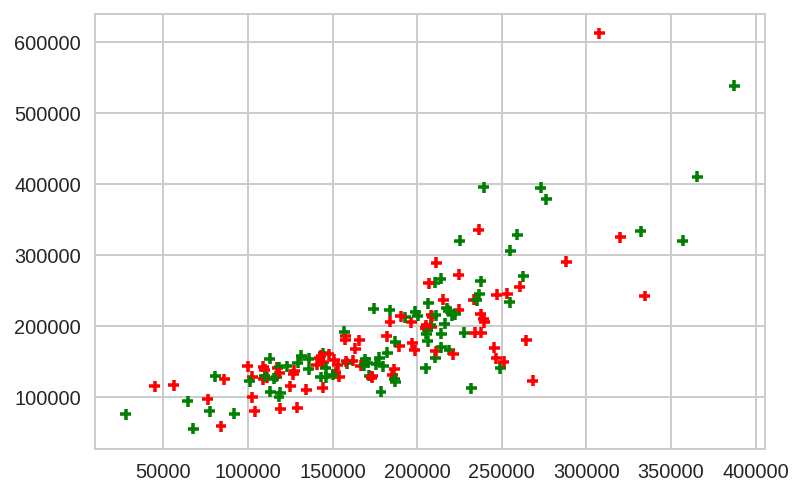

In [35]:
# Perform 10-fold cross validation
scores = cross_val_score(slr, X, y, cv=10)
print "Cross-validated scores:", scores
print "Mean Cross validation",scores.mean()



# Make cross validated predictions on the test sets
predictions = cross_val_predict(slr, X_test, y_test, cv=10)


# manually calcualte the r2
r2 = metrics.r2_score(y_test, predictions)
print "Cross-Predicted R2:", r2

plt.scatter(predictions, y_test, s=30, c=['r','g'], marker='+', zorder=10)

(1173, 5) (1173,)
(161, 5) (161,)
R2 for Train Data 0.70987351336
R2 for Test Data 0.767251489867
Coefficents  [ 35173.32387804  14291.5818366    6498.98086588 -17432.49699776
  14707.36813467]
Intercept  184496.965047
Residuals  2.09782887233e+12
Cross-validated scores: [ 0.52517476  0.630585    0.84672656  0.76170658  0.57239093  0.81830205
  0.65464114  0.84021729  0.76829588  0.84742083]
Cross-Predicted R2: 0.753356975219


/home/mahendra/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


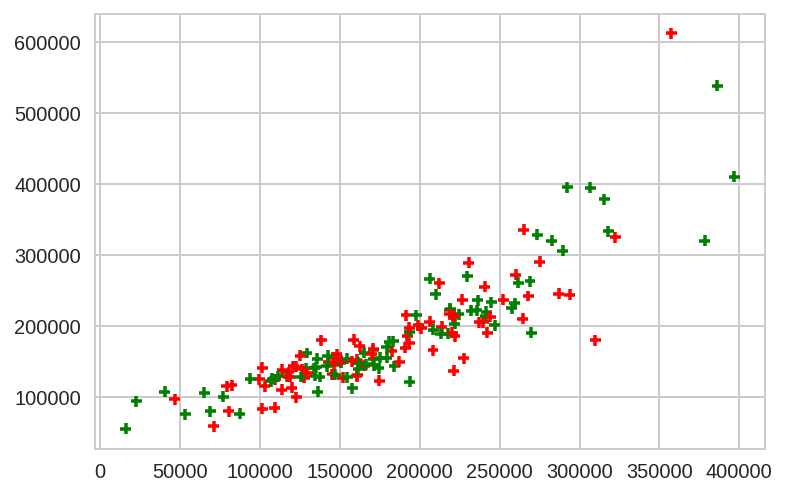

In [36]:
# Adding more and more variables and running
X_columns = ['GrLivArea', 'GarageArea','Total_Full_Bath','Age_while_Sale','TotalBsmtSF']
y_columns=['SalePrice']
X=fixed_with_sales[X_columns]
y=fixed_with_sales[y_columns]


X_train = fixed_with_sales[fixed_with_sales.YrSold < 2010].loc[:, X_columns]
y_train = fixed_with_sales['SalePrice'][fixed_with_sales.YrSold < 2010]


X_test = fixed_with_sales[fixed_with_sales.YrSold >= 2010].loc[:, X_columns]
y_test = fixed_with_sales['SalePrice'][fixed_with_sales.YrSold >= 2010]

Xs = ss.fit_transform(X)
X_train_s = ss.fit_transform(X_train)
X_test_s = ss.fit_transform(X_test)

print X_train_s.shape, y_train.shape
print X_test_s.shape, y_test.shape

slr.fit(X_train_s, y_train)

print "R2 for Train Data",slr.score(X_train_s, y_train)
print "R2 for Test Data",slr.score(X_test_s, y_test)

print "Coefficents ",slr.coef_
print "Intercept ",slr.intercept_
print "Residuals ",slr.residues_

# Perform 10-fold cross validation
scores = cross_val_score(slr, X_test,y_test, cv=10)
print "Cross-validated scores:", scores



# Make cross validated predictions on the test sets
predictions = cross_val_predict(slr, X_test, y_test, cv=10)


# manually calcualte the r2
r2 = metrics.r2_score(y_test, predictions)
print "Cross-Predicted R2:", r2
plt.scatter(predictions, y_test, s=30, c=['r','g'], marker='+', zorder=10)

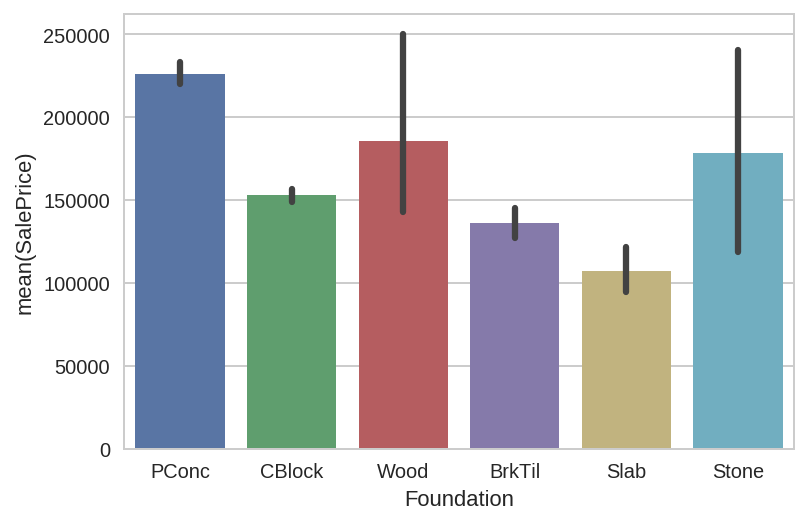

Foundation
BrkTil    136145
CBlock    152775
PConc     226358
Slab      107365
Stone     178595
Wood      185666
Name: SalePrice, dtype: int64


In [37]:
#Effects of categorical varibles in the price. 
sns.barplot(x="Foundation", y="SalePrice", data=house)
plt.show()
print house.groupby('Foundation').SalePrice.mean()


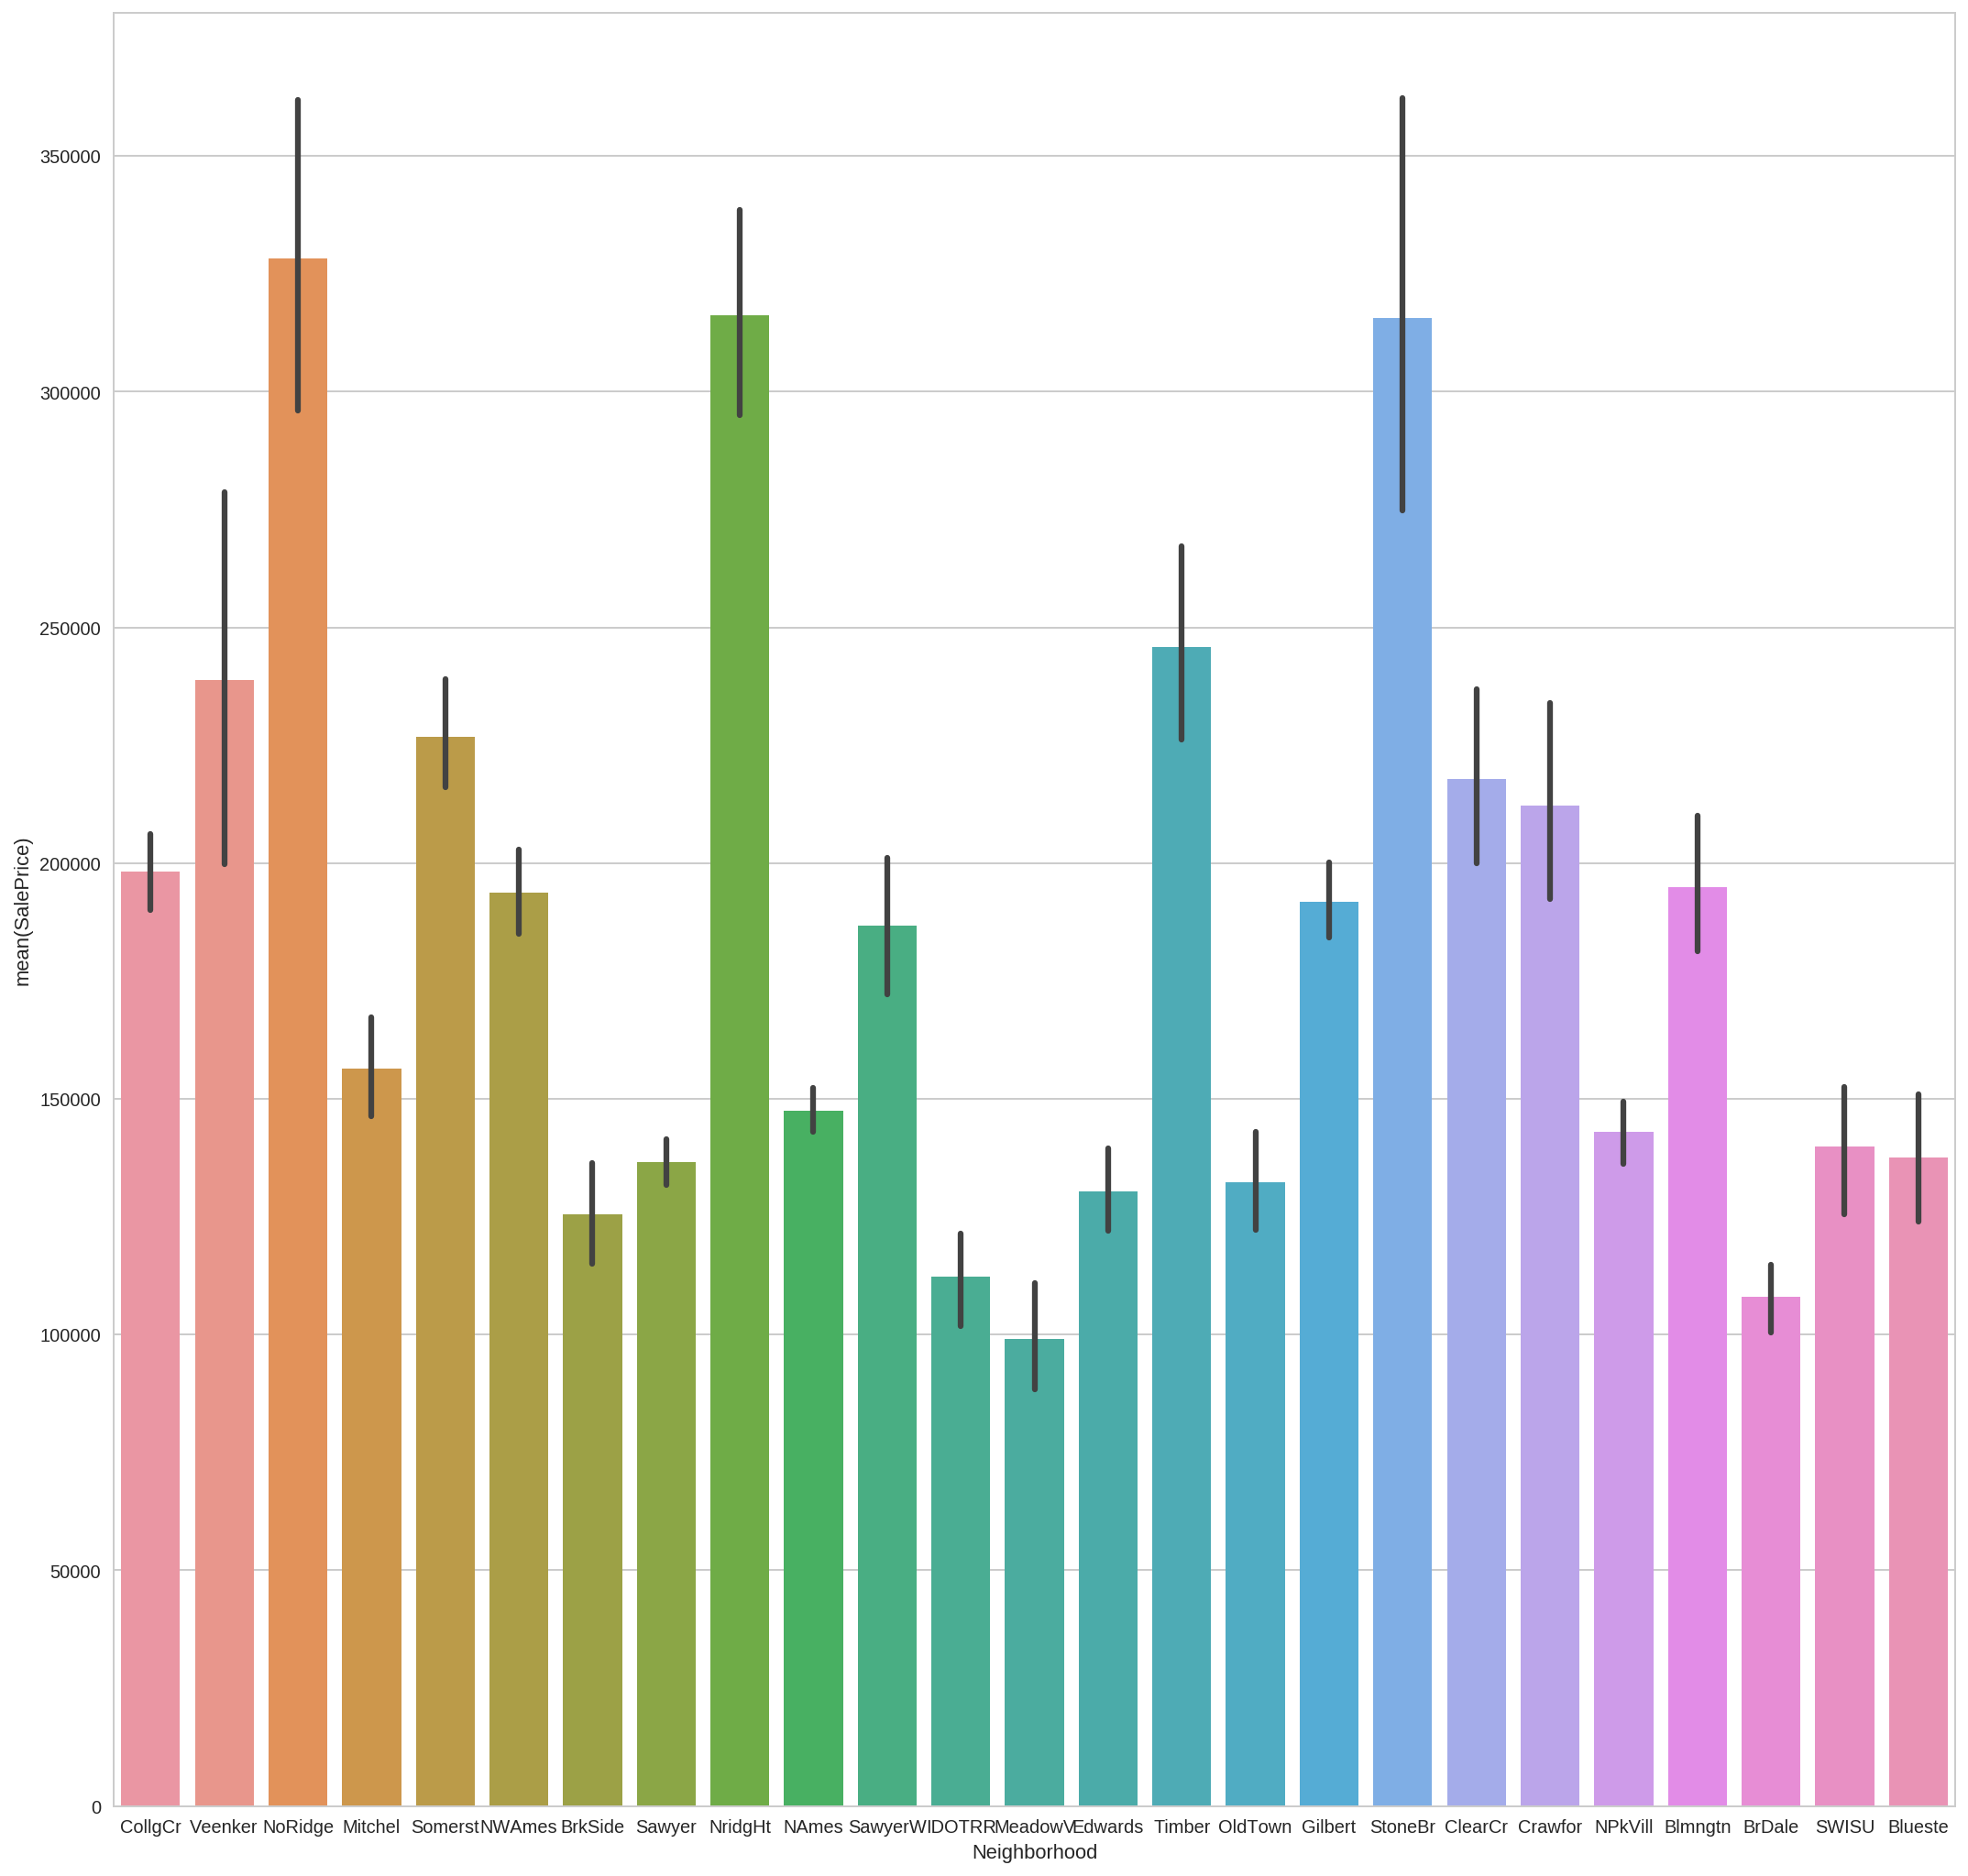

Neighborhood
Blmngtn    191000
Blueste    137500
BrDale     109500
BrkSide    127000
ClearCr    211000
CollgCr    197900
Crawfor    200362
Edwards    125500
Gilbert    180750
IDOTRR     116700
MeadowV     87000
Mitchel    152200
NAmes      142000
NPkVill    146500
NWAmes     188750
NoRidge    301500
NridgHt    315000
OldTown    120000
SWISU      138475
Sawyer     135000
SawyerW    179900
Somerst    226350
StoneBr    282000
Timber     228950
Veenker    218000
Name: SalePrice, dtype: int64


In [38]:
plt.figure(figsize=(18,18))
sns.barplot(x="Neighborhood", y="SalePrice", data=house)
plt.show()
print house.groupby('Neighborhood').SalePrice.median()


In [39]:
Fixed_Categorical=['Foundation','Neighborhood','Street','Alley','LotShape','LandContour','Utilities','LotConfig',
                  'LandSlope','BldgType','HouseStyle','BsmtQual','Electrical','GarageType']
Category_not_droped=['Condition1']

In [40]:
# # #Adding Foundation and neighborhood dummies 
# dummies=pd.get_dummies(house.Foundation,drop_first=True,prefix='Foundation')
# fixed_with_sales = pd.concat([fixed_with_sales, dummies], axis=1)
# dummies=pd.get_dummies(house.Neighborhood,drop_first=True,prefix='Neighborhood')
# fixed_with_sales = pd.concat([fixed_with_sales, dummies], axis=1)

In [41]:
Fixed_Categorical_df=house[Fixed_Categorical]
Category_not_droped_df=house[Category_not_droped]

In [42]:
Fixed_Categorical_df.shape

(1334, 14)

In [43]:
Category_not_droped_df.isnull().sum()

Condition1    0
dtype: int64

In [44]:
# Fixed_Categorical_df.isnull().sum()

for col in Fixed_Categorical_df.columns:
    if Fixed_Categorical_df[col].isnull().sum() > 0:
        print col,Fixed_Categorical_df[col].isnull().sum() 

Alley 1257
BsmtQual 36
Electrical 1
GarageType 67


In [45]:
print Fixed_Categorical_df.Alley.value_counts()
print Fixed_Categorical_df.BsmtQual.value_counts()
print Fixed_Categorical_df.GarageType.value_counts()
print Fixed_Categorical_df.Electrical.value_counts()


Grvl    43
Pave    34
Name: Alley, dtype: int64
Gd    584
TA    566
Ex    118
Fa     30
Name: BsmtQual, dtype: int64
Attchd     815
Detchd     344
BuiltIn     84
Basment     14
CarPort      6
2Types       4
Name: GarageType, dtype: int64
SBrkr    1227
FuseA      78
FuseF      25
FuseP       3
Name: Electrical, dtype: int64


In [46]:
# Alley, GarageType and BsmtQual have a value as 'NA'. This can be the one was accidently got Null
# Electrical has a mixed 
# Imputing the missing values with what it could have been.

In [47]:
Fixed_Categorical_df['Alley'].fillna("NoAlleyAccess", inplace=True)
Fixed_Categorical_df['GarageType'].fillna("NoGarage", inplace=True)
Fixed_Categorical_df['BsmtQual'].fillna("NoBasement", inplace=True)
Fixed_Categorical_df['Electrical'].fillna("Mix", inplace=True)
Fixed_Categorical_df.isnull().sum()

/home/mahendra/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:3295: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


Foundation      0
Neighborhood    0
Street          0
Alley           0
LotShape        0
LandContour     0
Utilities       0
LotConfig       0
LandSlope       0
BldgType        0
HouseStyle      0
BsmtQual        0
Electrical      0
GarageType      0
dtype: int64

In [48]:
Fixed_Categorical_dummies = pd.get_dummies(Fixed_Categorical_df,drop_first=True)
Category_not_droped_dummies=pd.get_dummies(Category_not_droped_df)# not dropping column because its not mutually exclusive

In [49]:
Fixed_Categorical_dummies.shape

(1334, 69)

In [50]:
Fixed_Categorical_dummies.head(2)

,Foundation_CBlock,Foundation_PConc,Foundation_Slab,Foundation_Stone,Foundation_Wood,Neighborhood_Blueste,Neighborhood_BrDale,Neighborhood_BrkSide,Neighborhood_ClearCr,Neighborhood_CollgCr,Neighborhood_Crawfor,Neighborhood_Edwards,Neighborhood_Gilbert,Neighborhood_IDOTRR,Neighborhood_MeadowV,Neighborhood_Mitchel,Neighborhood_NAmes,Neighborhood_NPkVill,Neighborhood_NWAmes,Neighborhood_NoRidge,Neighborhood_NridgHt,Neighborhood_OldTown,Neighborhood_SWISU,Neighborhood_Sawyer,Neighborhood_SawyerW,Neighborhood_Somerst,Neighborhood_StoneBr,Neighborhood_Timber,Neighborhood_Veenker,Street_Pave,Alley_NoAlleyAccess,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,LandContour_HLS,LandContour_Low,LandContour_Lvl,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,LandSlope_Mod,LandSlope_Sev,BldgType_2fmCon,BldgType_Duplex,BldgType_Twnhs,BldgType_TwnhsE,HouseStyle_1.5Unf,HouseStyle_1Story,HouseStyle_2.5Fin,HouseStyle_2.5Unf,HouseStyle_2Story,HouseStyle_SFoyer,HouseStyle_SLvl,BsmtQual_Fa,BsmtQual_Gd,BsmtQual_NoBasement,BsmtQual_TA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,GarageType_Attchd,GarageType_Basment,GarageType_BuiltIn,GarageType_CarPort,GarageType_Detchd,GarageType_NoGarage
0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0


In [51]:
fixed_with_sales=pd.concat([fixed_with_sales, Fixed_Categorical_dummies], axis=1)
fixed_with_sales=pd.concat([fixed_with_sales, Category_not_droped_dummies], axis=1)

In [52]:
fixed_with_sales.shape

(1334, 97)

In [53]:
# med=fixed_with_sales.LotFrontage.median()
# fixed_with_sales['LotFrontage'].fillna(med, inplace=True)
# med

In [54]:
fixed_with_sales.LotFrontage.isnull().sum()

0

In [55]:
fixed_with_sales.columns


Index([u'LotArea', u'LotFrontage', u'TotalBsmtSF', u'GrLivArea', u'GarageCars',
       u'GarageArea', u'BedroomAbvGr', u'TotRmsAbvGrd', u'Fireplaces',
       u'ScreenPorch', u'EnclosedPorch', u'OpenPorchSF', u'3SsnPorch',
       u'Total_Full_Bath', u'Total_Half_Bath', u'Age_while_Sale',
       u'Rebuild_age_while_sale', u'SalePrice', u'YrSold',
       u'Foundation_CBlock', u'Foundation_PConc', u'Foundation_Slab',
       u'Foundation_Stone', u'Foundation_Wood', u'Neighborhood_Blueste',
       u'Neighborhood_BrDale', u'Neighborhood_BrkSide',
       u'Neighborhood_ClearCr', u'Neighborhood_CollgCr',
       u'Neighborhood_Crawfor', u'Neighborhood_Edwards',
       u'Neighborhood_Gilbert', u'Neighborhood_IDOTRR',
       u'Neighborhood_MeadowV', u'Neighborhood_Mitchel', u'Neighborhood_NAmes',
       u'Neighborhood_NPkVill', u'Neighborhood_NWAmes',
       u'Neighborhood_NoRidge', u'Neighborhood_NridgHt',
       u'Neighborhood_OldTown', u'Neighborhood_SWISU', u'Neighborhood_Sawyer',
       u'Nei

In [56]:
predictors=[col for col in fixed_with_sales.columns if col not in ['YrSold','SalePrice']]
X=fixed_with_sales[predictors]
y=fixed_with_sales.SalePrice.values 
Xs = ss.fit_transform(X)

In [57]:
# Trying to figure out which feature scaloing to use.
# First doing Normal Linear Regression to compare with other values
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs, y, cv=10)

print linreg_scores
print np.mean(linreg_scores)

[ 0.89528207  0.84647218  0.8617414   0.74893925  0.84187561  0.84359293
  0.86068346  0.82982796  0.37255322  0.80211739]
0.790308546218


In [58]:
#Finding an optimal alpha to use in Ridge
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y)

print optimal_ridge.alpha_
print optimal_ridge.intercept_


230.043011977
184358.968516


In [59]:
ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=10)

print ridge_scores
print np.mean(ridge_scores)

[ 0.90687509  0.84597402  0.87340381  0.76887568  0.80432741  0.85444995
  0.8402668   0.80943779  0.43809514  0.82052244]
0.796222813059


In [60]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

print optimal_lasso.alpha_ 

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

420.785070638


...................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    1.4s finished


In [61]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print lasso_scores
print np.mean(lasso_scores)

[ 0.91046776  0.85196101  0.86989811  0.75521711  0.82927997  0.86174316
  0.8554999   0.82900676  0.33182676  0.81730572]
0.791220626579


In [62]:
lasso.fit(Xs, y)

Lasso(alpha=420.78507063754171, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [63]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs

,abs_coef,coef,variable
3,24732.876341,24732.876341,GrLivArea
73,17292.423365,-17292.423365,BsmtQual_Gd
75,16543.452544,-16543.452544,BsmtQual_TA
37,12076.916696,12076.916696,Neighborhood_NridgHt
4,10418.036727,10418.036727,GarageCars
36,8600.294137,8600.294137,Neighborhood_NoRidge
43,8374.981048,8374.981048,Neighborhood_StoneBr
15,8336.076895,-8336.076895,Age_while_Sale
2,7850.296316,7850.296316,TotalBsmtSF
64,7031.543097,-7031.543097,BldgType_TwnhsE


In [64]:
print 'Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0])

Percent variables zeroed out: 0.0187406296852


In [65]:
lasso_coefs_valid=[]
lasso_coefs_valid=[lasso_coefs.ix[index,'variable'] for index,coef in enumerate(lasso_coefs.abs_coef) if coef !=0]
len(lasso_coefs_valid)


70

In [66]:
predictors_lasso=lasso_coefs_valid

In [67]:
# from lasso run linear regrtession

In [68]:
linreg = LinearRegression()



(1173, 70) (1173,)
(161, 70) (161,)
R2 for Train Data 0.835796212164
R2 for Test Data 0.845376725642
Intercept  184496.965047
Residuals  1.18731471593e+12
Cross-validated scores: [ 0.79882712  0.58649481  0.76107115  0.80836731 -0.07367076  0.86319513
  0.62628063  0.73136754  0.67818029  0.71761242]
Cross-Predicted R2: 0.720129220066


/home/mahendra/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


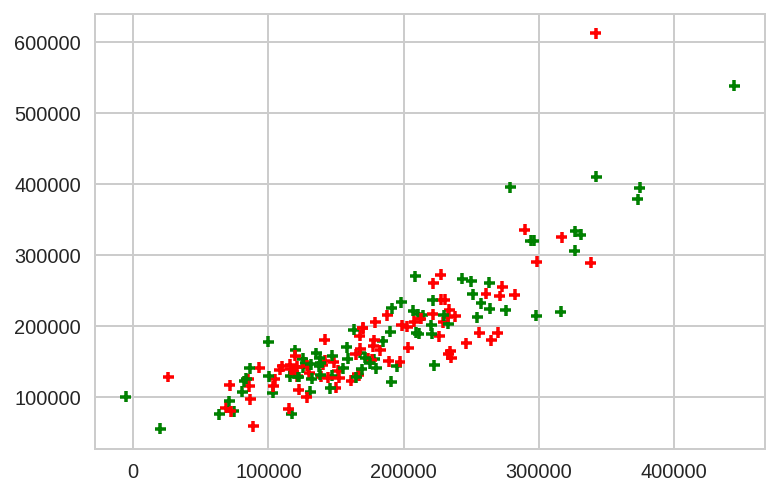

In [69]:
predictors=predictors_lasso
fixed_predictors=predictors_lasso
X=fixed_with_sales[predictors]
y=fixed_with_sales.SalePrice.values

X_train = fixed_with_sales[fixed_with_sales.YrSold < 2010].loc[:, predictors]
y_train = fixed_with_sales['SalePrice'][fixed_with_sales.YrSold < 2010]


X_test = fixed_with_sales[fixed_with_sales.YrSold >= 2010].loc[:, predictors]
y_test = fixed_with_sales['SalePrice'][fixed_with_sales.YrSold >= 2010]

Xs = ss.fit_transform(X)
X_train_s = ss.fit_transform(X_train)
X_test_s = ss.fit_transform(X_test)

print X_train_s.shape, y_train.shape
print X_test_s.shape, y_test.shape

linreg.fit(X_train_s, y_train)

print "R2 for Train Data",linreg.score(X_train_s, y_train)
print "R2 for Test Data",linreg.score(X_test_s, y_test)

# print "Coefficents ",linreg.coef_
print "Intercept ",linreg.intercept_
print "Residuals ",linreg.residues_

# Perform 10-fold cross validation
scores = cross_val_score(linreg,  X_test, y_test, cv=10)
print "Cross-validated scores:", scores



# Make cross validated predictions on the test sets
predictions = cross_val_predict(linreg, X_test, y_test, cv=10)


# manually calcualte the r2
r2 = metrics.r2_score(y_test, predictions)
print "Cross-Predicted R2:", r2
plt.scatter(predictions, y_test, s=30, c=['r','g'], marker='+', zorder=10)

In [70]:
# l1_ratios = np.linspace(0.01, 1.0, 25)

# optimal_enet = ElasticNetCV(l1_ratio=l1_ratios, n_alphas=100, cv=10,
#                             verbose=1)
# optimal_enet.fit(Xs, y)

# print optimal_enet.alpha_
# print optimal_enet.l1_ratio_

In [71]:
# enet = ElasticNet(alpha=optimal_enet.alpha_, l1_ratio=optimal_enet.l1_ratio_)

# enet_scores = cross_val_score(enet, Xs, y, cv=10)

# print enet_scores
# print np.mean(enet_scores)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**Your goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

In [72]:
# total_fixed=Fixed_Categorical+Category_not_droped+fixed
total_fixed_variables=[]
total_fixed_variables=fixed_continous+Category_not_droped+Fixed_Categorical
# fixed_variables.append(fixed_continous)
# fixed_variables.append(Category_not_droped)
# fixed_variables.append(Fixed_Categorical)

In [73]:
total_fixed_variables

['LotArea',
 'LotFrontage',
 'TotalBsmtSF',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'ScreenPorch',
 'EnclosedPorch',
 'OpenPorchSF',
 '3SsnPorch',
 'Total_Full_Bath',
 'Total_Half_Bath',
 'Age_while_Sale',
 'Rebuild_age_while_sale',
 'Condition1',
 'Foundation',
 'Neighborhood',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'HouseStyle',
 'BsmtQual',
 'Electrical',
 'GarageType']

In [74]:
renovatable=[col for col in house.columns if col not in total_fixed_variables]

In [75]:
renovatable

['level_0',
 'index',
 'Id',
 'MSSubClass',
 'MSZoning',
 'Condition2',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'RoofStyle',
 'RoofMatl',
 'Exterior1st',
 'Exterior2nd',
 'MasVnrType',
 'MasVnrArea',
 'ExterQual',
 'ExterCond',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinSF1',
 'BsmtFinType2',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'Heating',
 'HeatingQC',
 'CentralAir',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'KitchenAbvGr',
 'KitchenQual',
 'Functional',
 'FireplaceQu',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PavedDrive',
 'WoodDeckSF',
 'PoolArea',
 'PoolQC',
 'Fence',
 'MiscFeature',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SaleType',
 'SaleCondition',
 'SalePrice',
 'age']

In [76]:
eliminate=['level_0','index','Id','MSSubClass','MSZoning','Condition2','YearBuilt','YearRemodAdd',
           'Exterior2nd','MasVnrArea','BsmtFinSF1','BsmtFinSF2','Heating','GarageYrBlt','WoodDeckSF',
           'PoolArea','PoolQC','MoSold','SaleType','SaleCondition','BsmtFullBath','BsmtHalfBath','FullBath',
          'HalfBath','KitchenAbvGr','age','MiscVal','1stFlrSF','2ndFlrSF']

In [77]:
totat_eliminate=total_fixed_variables+eliminate

In [78]:
totat_eliminate

['LotArea',
 'LotFrontage',
 'TotalBsmtSF',
 'GrLivArea',
 'GarageCars',
 'GarageArea',
 'BedroomAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'ScreenPorch',
 'EnclosedPorch',
 'OpenPorchSF',
 '3SsnPorch',
 'Total_Full_Bath',
 'Total_Half_Bath',
 'Age_while_Sale',
 'Rebuild_age_while_sale',
 'Condition1',
 'Foundation',
 'Neighborhood',
 'Street',
 'Alley',
 'LotShape',
 'LandContour',
 'Utilities',
 'LotConfig',
 'LandSlope',
 'BldgType',
 'HouseStyle',
 'BsmtQual',
 'Electrical',
 'GarageType',
 'level_0',
 'index',
 'Id',
 'MSSubClass',
 'MSZoning',
 'Condition2',
 'YearBuilt',
 'YearRemodAdd',
 'Exterior2nd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'Heating',
 'GarageYrBlt',
 'WoodDeckSF',
 'PoolArea',
 'PoolQC',
 'MoSold',
 'SaleType',
 'SaleCondition',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'KitchenAbvGr',
 'age',
 'MiscVal',
 '1stFlrSF',
 '2ndFlrSF']

In [79]:
total_renovatable=[col for col in house.columns if col not in totat_eliminate]


In [80]:
Renovatable=house[total_renovatable]


In [81]:
Renovatable.head(2)

,OverallQual,OverallCond,RoofStyle,RoofMatl,Exterior1st,MasVnrType,ExterQual,ExterCond,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinType2,BsmtUnfSF,HeatingQC,CentralAir,LowQualFinSF,KitchenQual,Functional,FireplaceQu,GarageFinish,GarageQual,GarageCond,PavedDrive,Fence,MiscFeature,YrSold,SalePrice
0,7,5,Gable,CompShg,VinylSd,BrkFace,Gd,TA,TA,No,GLQ,Unf,150,Ex,Y,0,Gd,Typ,NaN,RFn,TA,TA,Y,NaN,NaN,2008,208500
1,6,8,Gable,CompShg,MetalSd,None,TA,TA,TA,Gd,ALQ,Unf,284,Ex,Y,0,TA,Typ,TA,RFn,TA,TA,Y,NaN,NaN,2007,181500


OverallQual
1      50150
2      60000
3      87500
4     108729
5     134225
6     162250
7     202500
8     270000
9     347500
10    426000
Name: SalePrice, dtype: int64


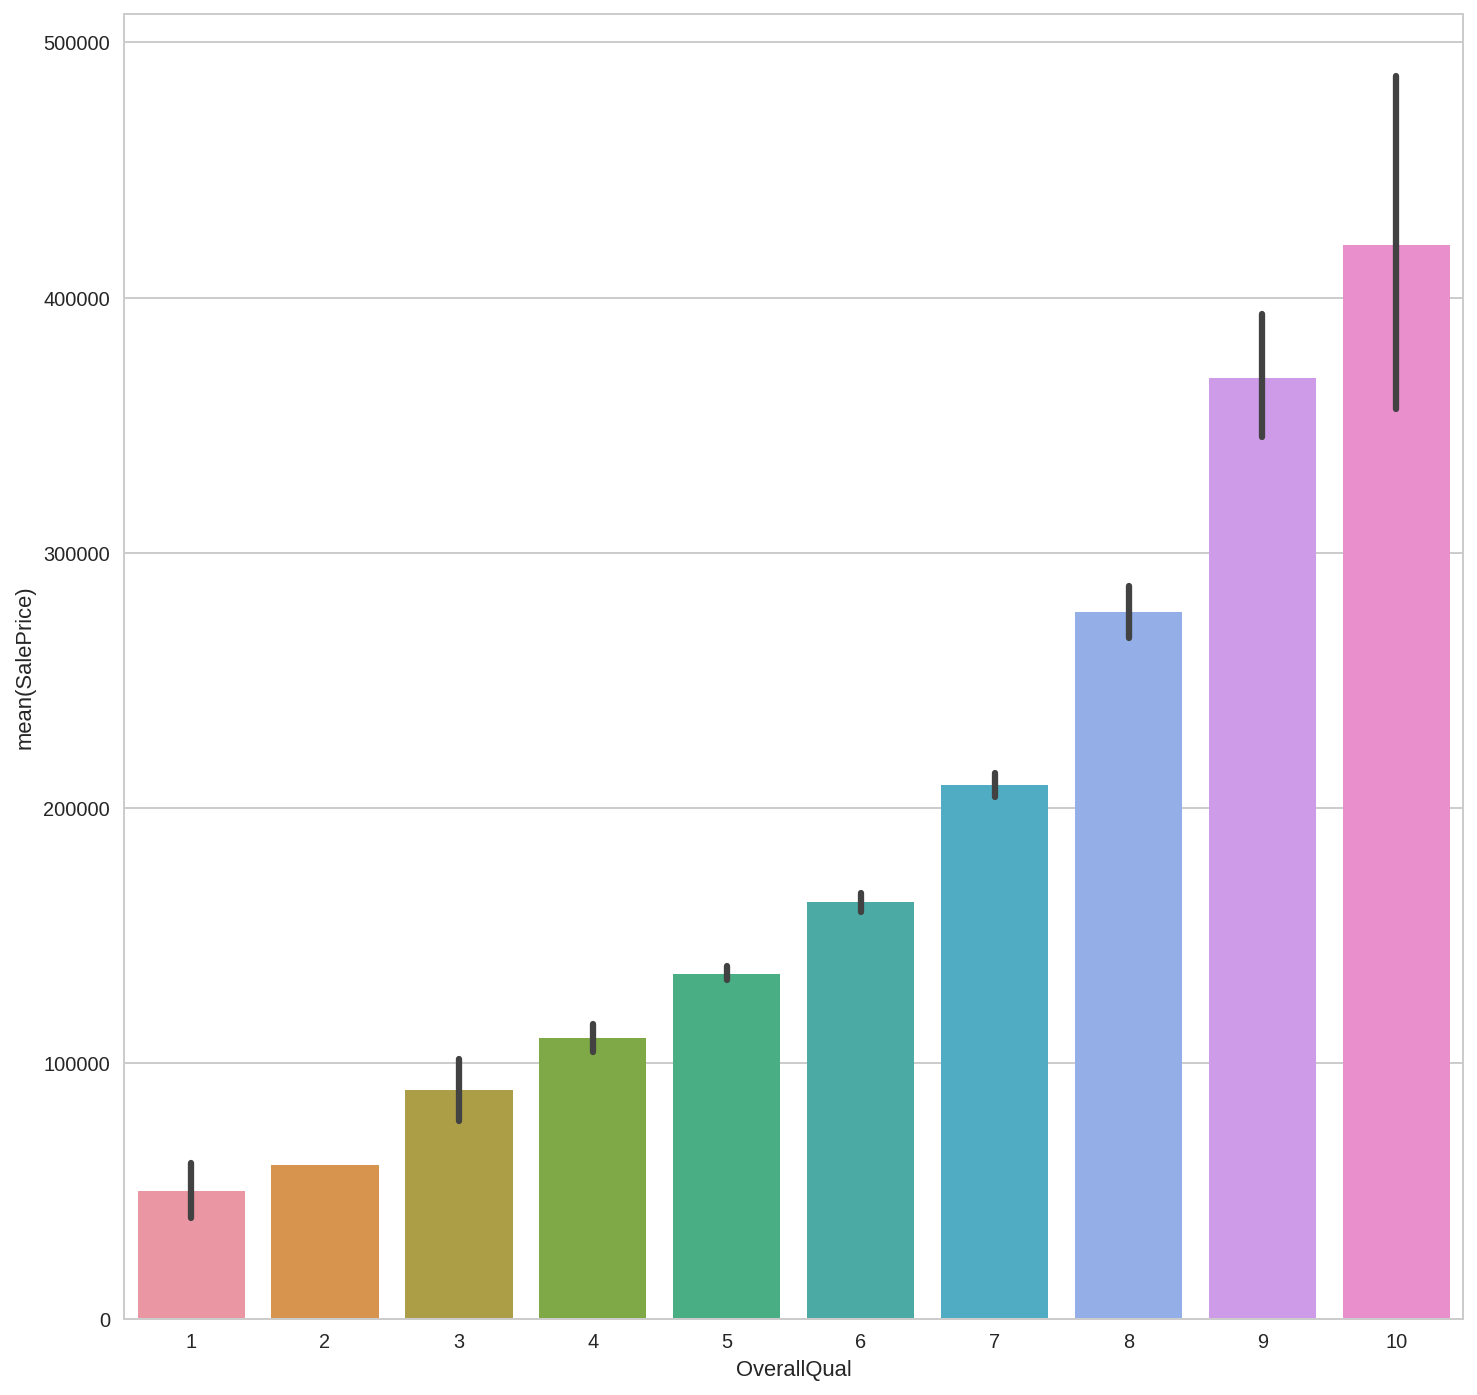

In [82]:
print Renovatable.groupby('OverallQual').SalePrice.median()
plt.figure(figsize=(12,12))
sns.barplot(x="OverallQual", y="SalePrice", data=Renovatable)
plt.show()

# From the data and figure it is clear that as the Overall Quality increase the price increase. And there is a
# clear correlation between Price and Overall Quality

OverallCond
1     61000
2     87000
3     87250
4    116250
5    188750
6    144000
7    146750
8    142000
9    178400
Name: SalePrice, dtype: int64


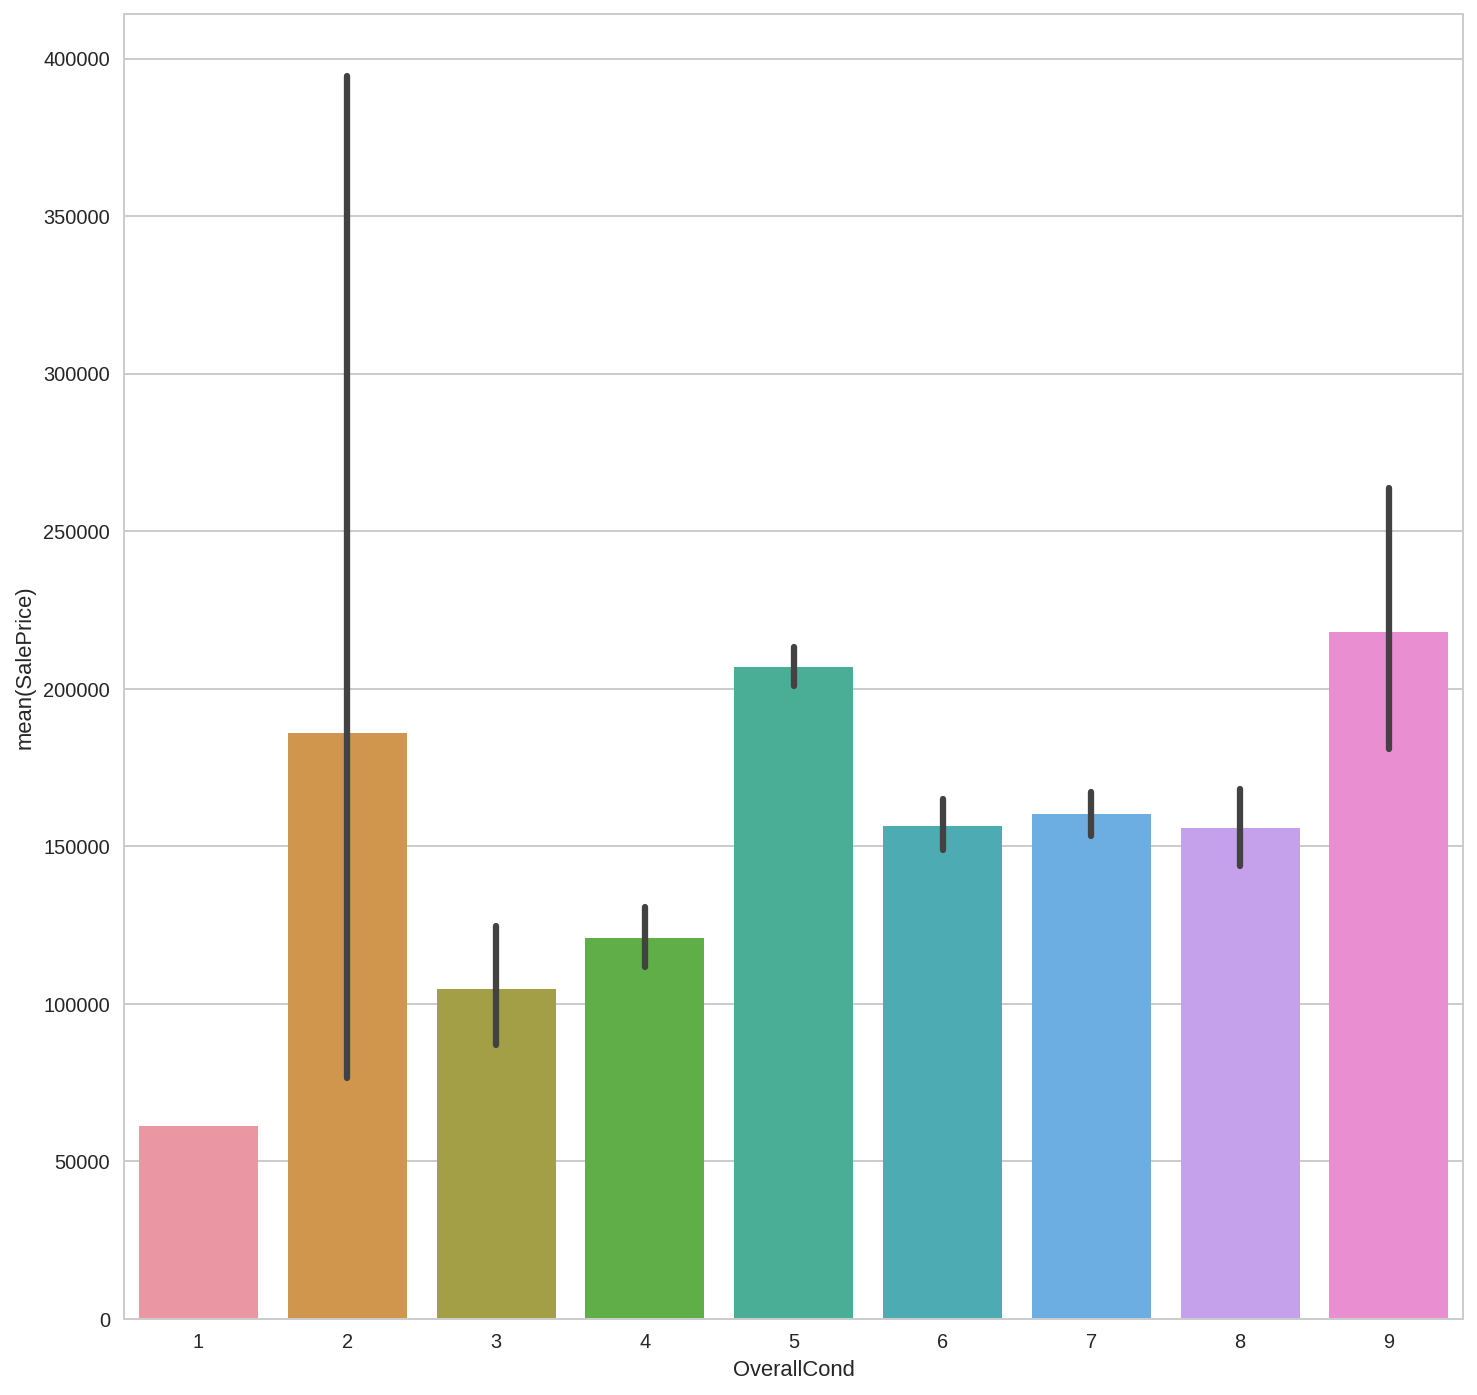

In [83]:
print Renovatable.groupby('OverallCond').SalePrice.median()
plt.figure(figsize=(12,12))
sns.barplot(x="OverallCond", y="SalePrice", data=Renovatable)
plt.show()

# From the median price data it is clear that as the Overall Condition increase the price increase. And there is a
# clear correlation between Price and Overall Condition
# the graph shows the mean value and there is change in price and it can be because of the outliers in those 
# groups.

In [84]:
corr_df=Renovatable.loc[:,['OverallCond','OverallQual','SalePrice']]
corr_df.corr()

#From the image and correlation matrix its clear OverallQual have high correlation to SalePrice and 
#lets see how effective it is to explain the SalePrice with the fixed model.

,OverallCond,OverallQual,SalePrice
OverallCond,1.000000,-0.120366,-0.102602
OverallQual,-0.120366,1.000000,0.794826
SalePrice,-0.102602,0.794826,1.000000


In [85]:
# From the graph and correlation matrix its clear if we can show the renovatable attributes of house 
# can explain the the overall Qualilty then its easy to show the dollar change for renovatable properties 
# through the change of price in Overall quality.

In [86]:
# Renovatable['OverallQual'] = Renovatable.OverallQual.map({1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten'})

In [87]:
# Renovatable['OverallCond'] = Renovatable.OverallCond.map({1:'one',2:'two',3:'three',4:'four',5:'five',6:'six',7:'seven',8:'eight',9:'nine',10:'ten'})

In [88]:
# Renovatable.OverallQual = Renovatable.OverallQual.map(lambda x: "one" if x==1 else "two" if x==2
#                                                      else "three" if x==3
#                                                      else "four" if x==4
#                                                      else "five" if x==5
#                                                      else "six" if x==6
#                                                      else "seven" if x==7
#                                                      else "eight" if x==8
#                                                      else "nine" if x==9
#                                                      else "ten" if x==10
#                                                      else x)

In [89]:
# Renovatable.OverallCond = Renovatable.OverallCond.map(lambda x: "one" if x==1
#                                                      else "two" if x==2
#                                                      else "three" if x==3
#                                                      else "four" if x==4
#                                                      else "five" if x==5
#                                                      else "six" if x==6
#                                                      else "seven" if x==7
#                                                      else "eight" if x==8
#                                                      else "nine" if x==9
#                                                      else "ten" if x==10
#                                                      else x) 

(1173, 71) (1173,)
(161, 71) (161,)
R2 for Train Data 0.835796515312
R2 for Test Data 0.845365328515
Intercept  184496.965047
Residuals  1.18731252394e+12
Cross-validated scores: [ 0.79882712  0.58649481  0.76107115  0.80836731 -0.07367076  0.86319513
  0.62628063  0.73136754  0.67818029  0.71761242]
Cross-Predicted R2: 0.720129220066


/home/mahendra/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


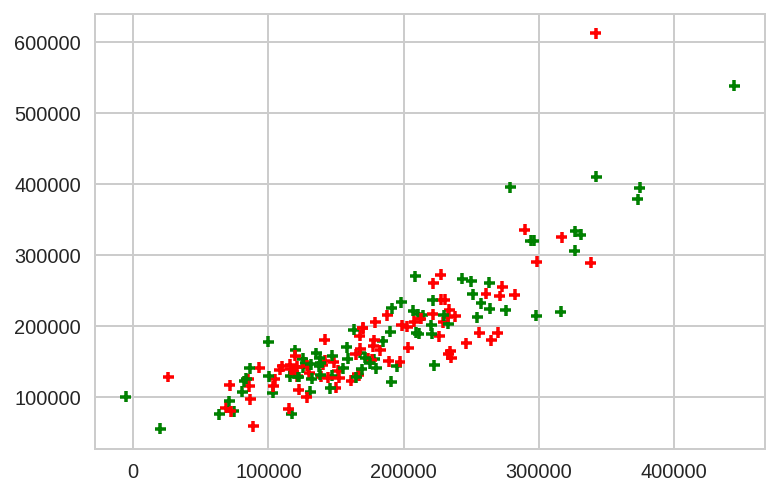

In [90]:
linreg=LinearRegression()
predictors=predictors_lasso
predictors.append('YrSold')
# fixed_predictors=predictors_lasso
X=fixed_with_sales[predictors]


X = pd.concat([X, Renovatable.OverallQual], axis=1)

y=fixed_with_sales.SalePrice.values

X_train = X[X.YrSold < 2010].loc[:, predictors]
y_train = fixed_with_sales['SalePrice'][fixed_with_sales.YrSold < 2010]


X_test = X[X.YrSold >= 2010].loc[:, predictors]
y_test = fixed_with_sales['SalePrice'][fixed_with_sales.YrSold >= 2010]

X.drop('YrSold',axis=1)
X_train.drop('YrSold',axis=1)
X_test.drop('YrSold',axis=1)

Xs = ss.fit_transform(X)
X_train_s = ss.fit_transform(X_train)
X_test_s = ss.fit_transform(X_test)

print X_train_s.shape, y_train.shape
print X_test_s.shape, y_test.shape

linreg.fit(X_train_s, y_train)

print "R2 for Train Data",linreg.score(X_train_s, y_train)
print "R2 for Test Data",linreg.score(X_test_s, y_test)

# print "Coefficents ",linreg.coef_
print "Intercept ",linreg.intercept_
print "Residuals ",linreg.residues_

# Perform 10-fold cross validation
scores = cross_val_score(linreg,  X_test, y_test, cv=10)
print "Cross-validated scores:", scores



# Make cross validated predictions on the test sets
predictions = cross_val_predict(linreg, X_test, y_test, cv=10)


# manually calcualte the r2
r2 = metrics.r2_score(y_test, predictions)
print "Cross-Predicted R2:", r2
plt.scatter(predictions, y_test, s=30, c=['r','g'], marker='+', zorder=10)

In [91]:
for col in Renovatable.columns:
    if house[col].dtypes != object:
        print col

OverallQual
OverallCond
BsmtUnfSF
LowQualFinSF
YrSold
SalePrice


In [92]:
Renovatable.isnull().sum()

OverallQual        0
OverallCond        0
RoofStyle          0
RoofMatl           0
Exterior1st        0
MasVnrType         8
ExterQual          0
ExterCond          0
BsmtCond          36
BsmtExposure      37
BsmtFinType1      36
BsmtFinType2      37
BsmtUnfSF          0
HeatingQC          0
CentralAir         0
LowQualFinSF       0
KitchenQual        0
Functional         0
FireplaceQu      610
GarageFinish      67
GarageQual        67
GarageCond        67
PavedDrive         0
Fence           1092
MiscFeature     1285
YrSold             0
SalePrice          0
dtype: int64

In [93]:
Renovatable['MasVnrType'].fillna("NotApplicable", inplace=True)
Renovatable['BsmtCond'].fillna("NoBasement", inplace=True)
Renovatable['BsmtExposure'].fillna("NoBasement", inplace=True)
Renovatable['FireplaceQu'].fillna("NoFireplace", inplace=True)
Renovatable['GarageFinish'].fillna("NoGarage", inplace=True)
Renovatable['GarageQual'].fillna("NoGarage", inplace=True)
Renovatable['GarageCond'].fillna("NoGarage", inplace=True)
Renovatable['Fence'].fillna("NoFence", inplace=True)
Renovatable['MiscFeature'].fillna("NoFence", inplace=True)
Renovatable['BsmtFinType1'].fillna("NoFence", inplace=True)
Renovatable['BsmtFinType2'].fillna("NoFence", inplace=True)


Renovatable.isnull().sum()

OverallQual     0
OverallCond     0
RoofStyle       0
RoofMatl        0
Exterior1st     0
MasVnrType      0
ExterQual       0
ExterCond       0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
BsmtUnfSF       0
HeatingQC       0
CentralAir      0
LowQualFinSF    0
KitchenQual     0
Functional      0
FireplaceQu     0
GarageFinish    0
GarageQual      0
GarageCond      0
PavedDrive      0
Fence           0
MiscFeature     0
YrSold          0
SalePrice       0
dtype: int64

In [94]:
Renovatable = pd.get_dummies(Renovatable,drop_first=True)

In [95]:
Renovatable.shape

(1334, 103)

In [96]:
renovatable_predictors=[col for col in Renovatable.columns if col not in ['YrSold']]
# X=Renovatable[renovatable_predictors]
# y=Renovatable.SalePrice.values 
# # Xs = ss.fit_transform(X)
renovatable_predictors

['OverallQual',
 'OverallCond',
 'BsmtUnfSF',
 'LowQualFinSF',
 'SalePrice',
 'RoofStyle_Gable',
 'RoofStyle_Gambrel',
 'RoofStyle_Hip',
 'RoofStyle_Mansard',
 'RoofStyle_Shed',
 'RoofMatl_CompShg',
 'RoofMatl_Membran',
 'RoofMatl_Metal',
 'RoofMatl_Roll',
 'RoofMatl_Tar&Grv',
 'RoofMatl_WdShake',
 'RoofMatl_WdShngl',
 'Exterior1st_AsphShn',
 'Exterior1st_BrkComm',
 'Exterior1st_BrkFace',
 'Exterior1st_CBlock',
 'Exterior1st_CemntBd',
 'Exterior1st_HdBoard',
 'Exterior1st_ImStucc',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior1st_Stucco',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_WdShing',
 'MasVnrType_BrkFace',
 'MasVnrType_None',
 'MasVnrType_NotApplicable',
 'MasVnrType_Stone',
 'ExterQual_Fa',
 'ExterQual_Gd',
 'ExterQual_TA',
 'ExterCond_Fa',
 'ExterCond_Gd',
 'ExterCond_Po',
 'ExterCond_TA',
 'BsmtCond_Gd',
 'BsmtCond_NoBasement',
 'BsmtCond_Po',
 'BsmtCond_TA',
 'BsmtExposure_Gd',
 'BsmtExposure_Mn',
 'BsmtExposure_No',
 'BsmtExposure_NoBasement'

In [97]:
tot_predictors=renovatable_predictors+fixed_predictors

fixed_with_sales.reset_index(range(0,len(fixed_with_sales)))
Renovatable.reset_index(range(0,len(Renovatable)))
# tot_predictors.append('YrSold')
# tot_predictors.append('SalePrice')
total_X=fixed_with_sales[fixed_predictors].copy()

total_X = pd.concat([total_X,Renovatable[renovatable_predictors]], axis=1)

X=total_X.copy()
y=X.SalePrice.values

X_train = X[X.YrSold < 2010].loc[:, tot_predictors]
y_train = X['SalePrice'][X.YrSold < 2010]


X_test = X[X.YrSold >= 2010].loc[:, tot_predictors]
y_test = X['SalePrice'][X.YrSold >= 2010]


X.drop(['YrSold', 'SalePrice'], axis=1, inplace=True)
X_train.drop(['YrSold', 'SalePrice'], axis=1, inplace=True)
X_test.drop(['YrSold', 'SalePrice'], axis=1, inplace=True)

Xs = ss.fit_transform(X)
# X_train_s = ss.fit_transform(X_train)
# X_test_s = ss.fit_transform(X_test)

# print X_train_s.shape, y_train.shape
# print X_test_s.shape, y_test.shape

# linreg.fit(X_train_s, y_train)

# print "R2 for Train Data",linreg.score(X_train_s, y_train)
# print "R2 for Test Data",linreg.score(X_test_s, y_test)

# # print "Coefficents ",linreg.coef_
# print "Intercept ",linreg.intercept_
# print "Residuals ",linreg.residues_

# # Perform 10-fold cross validation
# scores = cross_val_score(linreg,  X_test, y_test, cv=10)
# print "Cross-validated scores:", scores



# # Make cross validated predictions on the test sets
# predictions = cross_val_predict(linreg, X_test, y_test, cv=10)

# # manually calcualte the r2
# r2 = metrics.r2_score(y_test, predictions)
# print "Cross-Predicted R2:", r2
# plt.scatter(predictions, y_test, s=30, c=['r','g'], marker='+', zorder=10)

In [98]:
# Trying to figure out which feature scaloing to use.
# First doing Normal Linear Regression to compare with other values
linreg = LinearRegression()

linreg_scores = cross_val_score(linreg, Xs, y, cv=10)

print linreg_scores
print np.mean(linreg_scores)

[ -3.25575314e+22  -7.59849143e+21  -1.00565326e+23   6.88936618e-01
   9.10724152e-01   8.93371058e-01  -8.04081078e+22   8.50290091e-01
  -6.64033158e+22  -3.98630354e+25]
-4.01505681747e+24


In [99]:
#Finding an optimal alpha to use in Ridge
ridge_alphas = np.logspace(0, 5, 200)

optimal_ridge = RidgeCV(alphas=ridge_alphas, cv=10)
optimal_ridge.fit(Xs, y)

print optimal_ridge.alpha_
print optimal_ridge.intercept_


ridge = Ridge(alpha=optimal_ridge.alpha_)

ridge_scores = cross_val_score(ridge, Xs, y, cv=10)

print ridge_scores
print np.mean(ridge_scores)

258.261876068
184358.968516
[ 0.91687362  0.90543175  0.90021702  0.79949713  0.8610701   0.86734027
  0.86540519  0.81717586  0.50402785  0.88548278]
0.832252157531


In [100]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, verbose=1)
optimal_lasso.fit(Xs, y)

print optimal_lasso.alpha_ 

lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso_scores = cross_val_score(lasso, Xs, y, cv=10)

print lasso_scores
print np.mean(lasso_scores)

........................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

631.660548351
[ 0.91688304  0.91687239  0.90054647  0.77980065  0.87460472  0.88014175
  0.86552397  0.82830343  0.43139832  0.89382728]
0.828790199466


In [101]:
lasso.fit(Xs, y)


lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs 
print 'Percent variables zeroed out:', np.sum((lasso.coef_ == 0))/float(X.shape[0])



Percent variables zeroed out: 0.0592203898051


In [102]:
lasso_coefs_valid=[]
lasso_coefs_valid=[lasso_coefs.ix[index,'variable'] for index,coef in enumerate(lasso_coefs.abs_coef) if coef !=0]
len(lasso_coefs_valid) 
predictors_lasso=lasso_coefs_valid

(1173, 92) (1173,)
(161, 92) (161,)
R2 for Train Data 0.892443186994
R2 for Test Data 0.498006442542
Intercept  184496.965047
Residuals  []
Cross-validated scores: [ 0.55830567 -0.16570321  0.84810511  0.86032549 -0.03300593  0.85077738
  0.6368749   0.87397209  0.78655732  0.65236223]
Cross-Predicted R2: 0.696684432469


/home/mahendra/anaconda2/lib/python2.7/site-packages/sklearn/utils/deprecation.py:70: DeprecationWarning: Function residues_ is deprecated; ``residues_`` is deprecated and will be removed in 0.19
  warnings.warn(msg, category=DeprecationWarning)


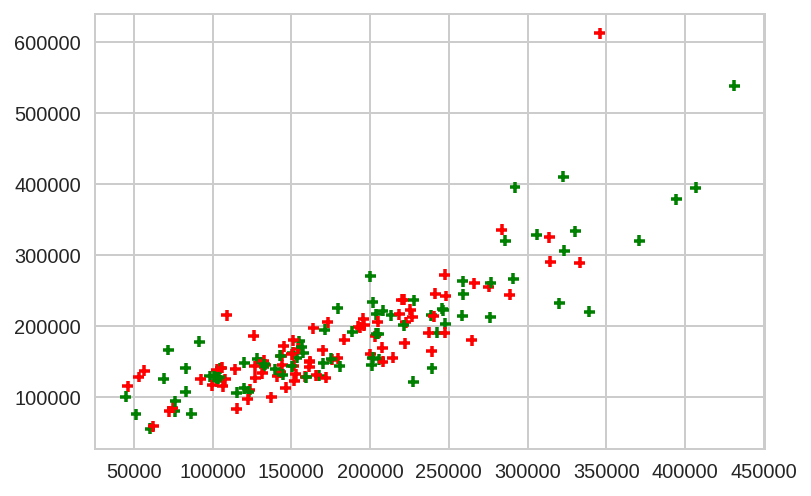

In [103]:
predictors=predictors_lasso
tot_predictors=predictors
tot_predictors.append("SalePrice")
tot_predictors.append("YrSold")

X=total_X.loc[:,tot_predictors]
X.reset_index(range(0,len(X)))
y=X.SalePrice.values

X_train = X[X.YrSold < 2010].loc[:, tot_predictors]
y_train = X['SalePrice'][X.YrSold < 2010]


X_test = X[X.YrSold >= 2010].loc[:, tot_predictors]
y_test = X['SalePrice'][X.YrSold >= 2010]


X.drop(['YrSold', 'SalePrice'], axis=1, inplace=True)
X_train.drop(['YrSold', 'SalePrice'], axis=1, inplace=True)
X_test.drop(['YrSold', 'SalePrice'], axis=1, inplace=True)

Xs = ss.fit_transform(X)
X_train_s = ss.fit_transform(X_train)
X_test_s = ss.fit_transform(X_test)

print X_train_s.shape, y_train.shape
print X_test_s.shape, y_test.shape

linreg.fit(X_train_s, y_train)

print "R2 for Train Data",linreg.score(X_train_s, y_train)
print "R2 for Test Data",linreg.score(X_test_s, y_test)

# print "Coefficents ",linreg.coef_
print "Intercept ",linreg.intercept_
print "Residuals ",linreg.residues_

# Perform 10-fold cross validation
scores = cross_val_score(linreg,  X_test, y_test, cv=10)
print "Cross-validated scores:", scores



# Make cross validated predictions on the test sets
predictions = cross_val_predict(linreg, X_test, y_test, cv=10)

# manually calcualte the r2
r2 = metrics.r2_score(y_test, predictions)
print "Cross-Predicted R2:", r2
plt.scatter(predictions, y_test, s=30, c=['r','g'], marker='+', zorder=10)

In [104]:
# Since cross validated score reduces in this model. Its better to explain the price from model 1 itself

<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [2]:
house = pd.read_csv('/home/mahendra/Desktop/Documents/Project3/housing.csv')
house.shape

(1460, 81)

In [3]:
house.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500


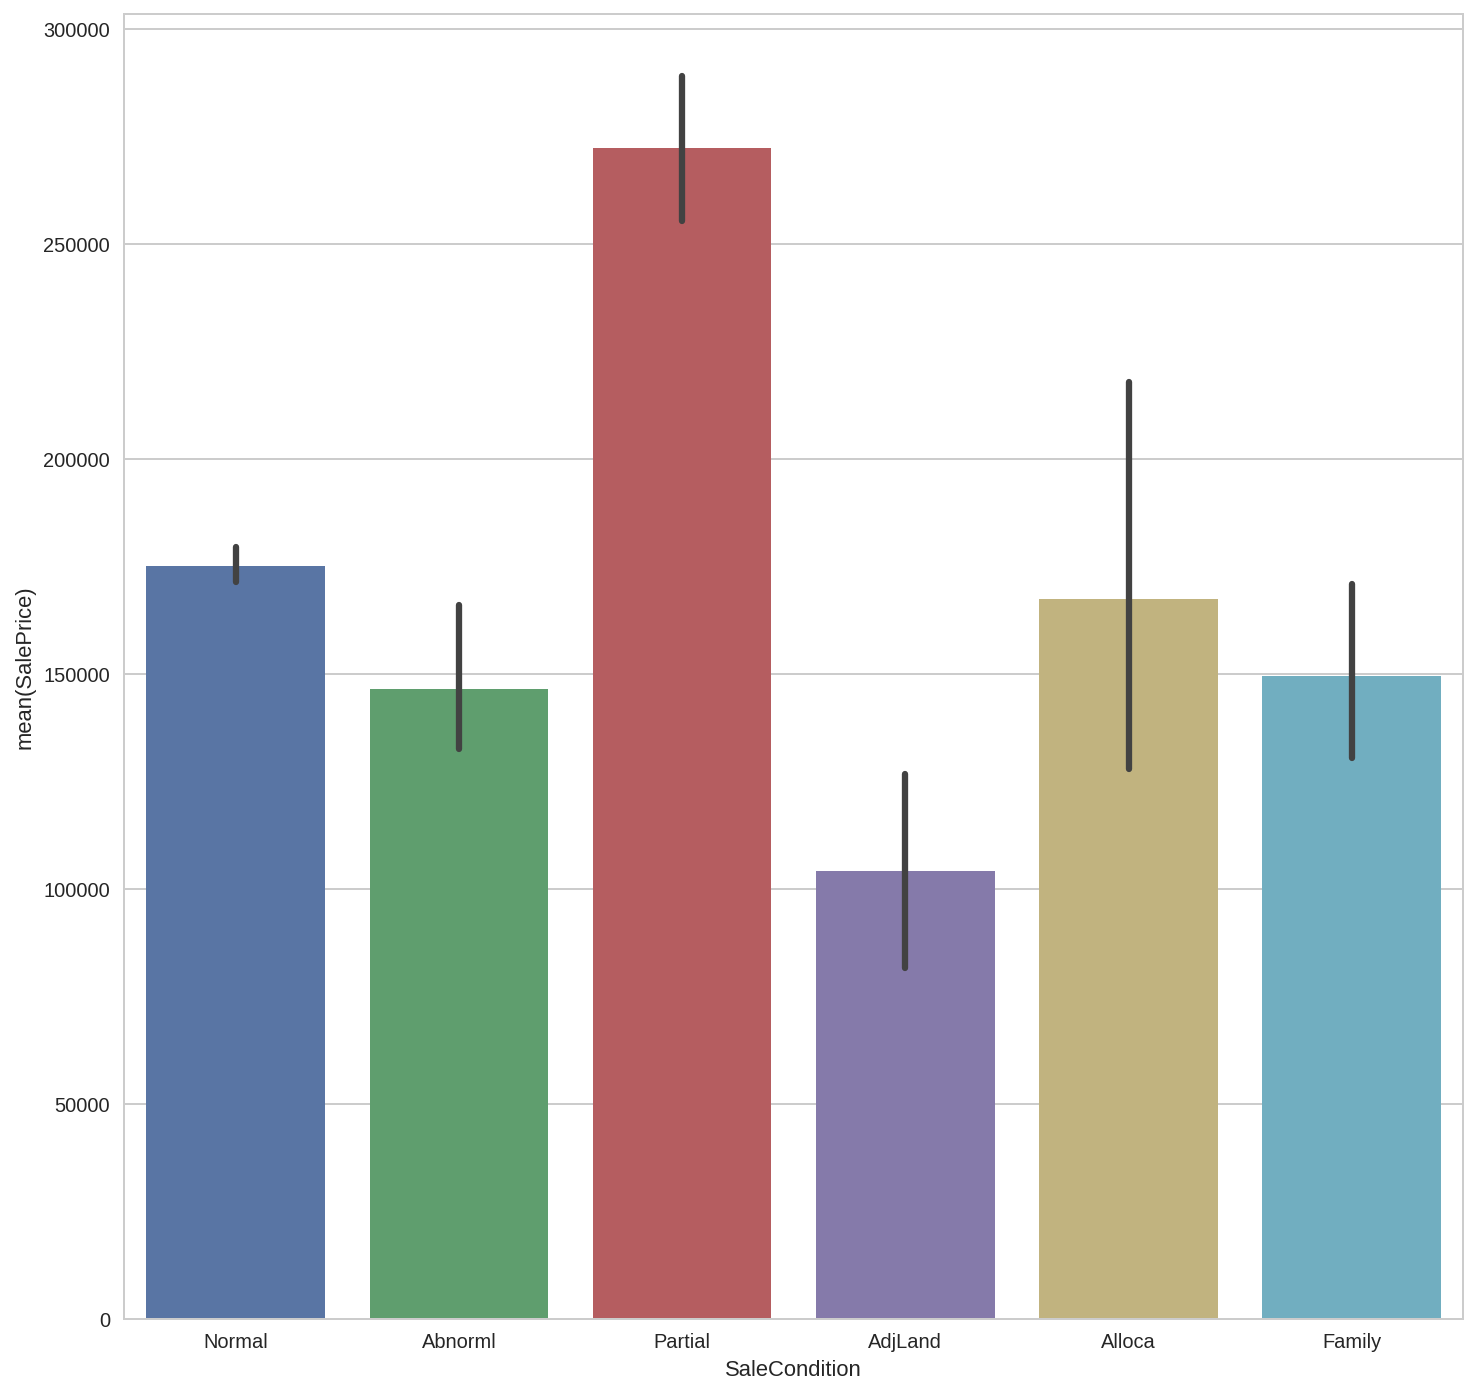

In [4]:
house.SaleCondition.value_counts()
plt.figure(figsize=(12,12))
sns.barplot(x="SaleCondition", y="SalePrice", data=house)
plt.show()

In [5]:
house_abnormal=house.copy()

In [6]:
dropping_list=[]
for col in house_abnormal.columns:
    if house[col].dtypes != object:
        dropping_list.append(col)
dropping_list

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '1stFlrSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageYrBlt',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'SalePrice']

In [7]:
house_abnormal.drop(dropping_list,axis=1,inplace=True)

In [8]:
house_abnormal.columns

Index([u'MSZoning', u'Street', u'Alley', u'LotShape', u'LandContour',
       u'Utilities', u'LotConfig', u'LandSlope', u'Neighborhood',
       u'Condition1', u'Condition2', u'BldgType', u'HouseStyle', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual', u'BsmtCond',
       u'BsmtExposure', u'BsmtFinType1', u'BsmtFinType2', u'Heating',
       u'HeatingQC', u'CentralAir', u'Electrical', u'KitchenQual',
       u'Functional', u'FireplaceQu', u'GarageType', u'GarageFinish',
       u'GarageQual', u'GarageCond', u'PavedDrive', u'PoolQC', u'Fence',
       u'MiscFeature', u'SaleType', u'SaleCondition'],
      dtype='object')

In [9]:
house_abnormal['Abnormal'] = [1 if value == 'Abnorml' else 0 for value in house_abnormal.SaleCondition]
house_abnormal.drop('SaleCondition', axis = 1, inplace = True)

In [10]:
house_abnormal['Abnormal'].value_counts()

0    1359
1     101
Name: Abnormal, dtype: int64

In [11]:
house_abnormal.isnull().sum()
for col in house_abnormal.columns:
    if house_abnormal[col].isnull().sum()>0:
        print col,house_abnormal[col].isnull().sum()

Alley 1369
MasVnrType 8
BsmtQual 37
BsmtCond 37
BsmtExposure 38
BsmtFinType1 37
BsmtFinType2 38
Electrical 1
FireplaceQu 690
GarageType 81
GarageFinish 81
GarageQual 81
GarageCond 81
PoolQC 1453
Fence 1179
MiscFeature 1406


In [12]:
house_abnormal['MasVnrType'].fillna("NotApplicable", inplace=True)
house_abnormal['BsmtCond'].fillna("NoBasement", inplace=True)
house_abnormal['BsmtExposure'].fillna("NoBasement", inplace=True)
house_abnormal['FireplaceQu'].fillna("NoFireplace", inplace=True)
house_abnormal['GarageFinish'].fillna("NoGarage", inplace=True)
house_abnormal['GarageQual'].fillna("NoGarage", inplace=True)
house_abnormal['GarageCond'].fillna("NoGarage", inplace=True)
house_abnormal['Fence'].fillna("NoFence", inplace=True)
house_abnormal['MiscFeature'].fillna("NoFence", inplace=True)
house_abnormal['BsmtFinType1'].fillna("NoFence", inplace=True)
house_abnormal['BsmtFinType2'].fillna("NoFence", inplace=True)
house_abnormal['Alley'].fillna("NoAlley", inplace=True)
house_abnormal['BsmtQual'].fillna("NoBasement", inplace=True)
house_abnormal['Electrical'].fillna("Mixed", inplace=True)
house_abnormal['GarageType'].fillna("NoGarage", inplace=True)
house_abnormal['PoolQC'].fillna("NoPool", inplace=True)


house_abnormal.isnull().sum()

MSZoning        0
Street          0
Alley           0
LotShape        0
LandContour     0
Utilities       0
LotConfig       0
LandSlope       0
Neighborhood    0
Condition1      0
Condition2      0
BldgType        0
HouseStyle      0
RoofStyle       0
RoofMatl        0
Exterior1st     0
Exterior2nd     0
MasVnrType      0
ExterQual       0
ExterCond       0
Foundation      0
BsmtQual        0
BsmtCond        0
BsmtExposure    0
BsmtFinType1    0
BsmtFinType2    0
Heating         0
HeatingQC       0
CentralAir      0
Electrical      0
KitchenQual     0
Functional      0
FireplaceQu     0
GarageType      0
GarageFinish    0
GarageQual      0
GarageCond      0
PavedDrive      0
PoolQC          0
Fence           0
MiscFeature     0
SaleType        0
Abnormal        0
dtype: int64

In [13]:
predictors=list(house_abnormal.columns)
predictors.remove('Abnormal')

In [14]:
X=house_abnormal[predictors]
y=house_abnormal.Abnormal.values

In [15]:
X=pd.get_dummies(X,drop_first=True)

X.shape

(1460, 220)

In [16]:
predictors=X.columns
X.head(2)

,MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Pave,Alley_NoAlley,Alley_Pave,LotShape_IR2,LotShape_IR3,LotShape_Reg,...,MiscFeature_Shed,MiscFeature_TenC,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD
0,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
1,0,0,1,0,1,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [18]:
# build the selector (we'll build one with each score type)
skb_f = SelectKBest(f_classif, k=5)
skb_chi2 = SelectKBest(chi2, k=5)

print skb_f
print skb_chi2


SelectKBest(k=5, score_func=<function f_classif at 0x7f5a2b3fa9b0>)
SelectKBest(k=5, score_func=<function chi2 at 0x7f5a2b3fa6e0>)


In [19]:
# train the selector on our data
skb_f.fit(X, y)
skb_chi2.fit(X, y)

# examine results
kbest = pd.DataFrame([predictors, list(skb_f.scores_), list(skb_chi2.scores_)], 
                     index=['feature','f_classif','chi2 score']).T.sort_values('f_classif', ascending=False)
kbest

,feature,f_classif,chi2 score
218,SaleType_Oth,41.5451,40.3663
219,SaleType_WD,29.423,3.81777
91,Exterior1st_Stone,27.4169,26.9109
130,BsmtQual_TA,15.8701,8.73258
1,MSZoning_RH,15.0067,14.7112
185,GarageType_NoGarage,14.433,13.5171
191,GarageQual_NoGarage,14.433,13.5171
196,GarageCond_NoGarage,14.433,13.5171
186,GarageFinish_NoGarage,14.433,13.5171
177,FireplaceQu_NoFireplace,14.3608,7.51028


In [21]:
lr = LogisticRegression()
selector = RFECV(lr, step=1, cv=10, verbose=False)
selector = selector.fit(X, y)

print selector.support_
print selector.ranking_

# verbose =  how many times it will conduct the Feature Elimination

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False  True
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False Fa

In [22]:
# the column names correspond to the one above.  RFECV  excluded a lot of features and just kept only 5 columns
rfecv_columns = np.array(predictors)[selector.support_]
rfecv_columns 

array(['Neighborhood_NridgHt', 'Exterior1st_Stone', 'SaleType_New',
       'SaleType_Oth', 'SaleType_WD'], dtype=object)

In [24]:
# Since RFECV model selected only 5 variables lets try how the prediction comes using those 5 compared 
# to the best 5 of K-best and using those columns lets see how logistics regression works for penality l1
kbest_columns = kbest.feature.values[0:5]
kbest_columns

array(['SaleType_Oth', 'SaleType_WD', 'Exterior1st_Stone', 'BsmtQual_TA',
       'MSZoning_RH'], dtype=object)

In [25]:
baseline_acc = 1. - y.mean()
baseline_acc

0.93082191780821921

In [26]:
predictors=rfecv_columns
predictors

array(['Neighborhood_NridgHt', 'Exterior1st_Stone', 'SaleType_New',
       'SaleType_Oth', 'SaleType_WD'], dtype=object)

In [27]:
# We will run logistic regression for both Kbest and RFCEV featured columns as X and see results

X_RFCEV=X[predictors]

In [28]:

X_train, X_test, y_train, y_test = train_test_split(X_RFCEV, y, test_size=0.5, random_state=12)

In [29]:
# Lets set our model parameters 
logreg_cv = LogisticRegressionCV(Cs=100, cv=5, penalty='l1', scoring='accuracy', solver='liblinear')
logreg_cv.fit(X_train, y_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='accuracy', solver='liblinear', tol=0.0001,
           verbose=0)

In [30]:
# find best C per class  
print 'best C for class:'

# Building a dictionary that does a regression for each of the Y classes
# after the fit it grabs the C value for said logistic regression and puts them together.
best_C = {logreg_cv.classes_[i]:x for i, (x, c) in enumerate(zip(logreg_cv.C_, logreg_cv.classes_))}
print(best_C)

best C for class:
{0: 0.0001}


In [31]:
logreg_1 = LogisticRegression(C=best_C[0], penalty='l1', solver='liblinear')

In [32]:
logreg_1.fit(X_train, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [33]:
Y_1_pred = logreg_1.predict(X_test)

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
# stores confusion matrix for Y Test and Y Pred  
conmat_1 = confusion_matrix(y_test, Y_1_pred, labels=logreg_1.classes_)
# converts np.matrix format matrix to a dataframe and adds index and column names
conmat_1 = pd.DataFrame(conmat_1, columns=logreg_1.classes_, index=logreg_1.classes_)

In [36]:
print 'best params for non-crime:'
print conmat_1

best params for non-crime:
     0  1
0  686  0
1   44  0


In [ ]:
# Which shows it doesn't even predict any of them to be abnormal which intern shows its  
#  not a good model that predicts the output.


In [66]:
#Lets try with the top 100 k-best variables to predict the abnormal sale conditon
kbest_columns = kbest.feature.values[0:100]

In [67]:
predictors=kbest_columns


In [68]:
X_Kbest=X[predictors]
X_train, X_test, y_train, y_test = train_test_split(X_Kbest, y, test_size=0.5, random_state=12)

In [69]:
# Lets set our model parameters 
logreg_cv = LogisticRegressionCV(Cs=100, cv=5, penalty='l1', scoring='accuracy', solver='liblinear')
logreg_cv.fit(X_train, y_train)

LogisticRegressionCV(Cs=100, class_weight=None, cv=5, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=100,
           multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
           refit=True, scoring='accuracy', solver='liblinear', tol=0.0001,
           verbose=0)

In [70]:
# find best C per class  
print 'best C for class:'

# Building a dictionary that does a regression for each of the Y classes
# after the fit it grabs the C value for said logistic regression and puts them together.
best_C = {logreg_cv.classes_[i]:x for i, (x, c) in enumerate(zip(logreg_cv.C_, logreg_cv.classes_))}
print(best_C)

best C for class:
{0: 1.5922827933410939}


In [71]:
logreg_2 = LogisticRegression(C=best_C[0], penalty='l1', solver='liblinear')

In [72]:
logreg_2.fit(X_train, y_train)

LogisticRegression(C=1.5922827933410939, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [73]:
Y_2_pred = logreg_2.predict(X_test)
# stores confusion matrix for Y Test and Y Pred  
conmat_2 = confusion_matrix(y_test, Y_2_pred, labels=logreg_2.classes_)
# converts np.matrix format matrix to a dataframe and adds index and column names
conmat_2 = pd.DataFrame(conmat_2, columns=logreg_2.classes_, index=logreg_2.classes_)

In [74]:
print 'best params for non-crime:'
print conmat_2

best params for non-crime:
     0  1
0  678  8
1   38  6


In [ ]:
# Still its not the best way to predict since major percent of the abnormals are predicted as normal
